# 🏠 Singapore HDB Resale Price Prediction

This project leverages machine learning to predict the resale prices of HDB flats in Singapore. It covers data preprocessing, model training and evaluation, and features an interactive Streamlit web application for real-time predictions.

---

## 📁 Project Structure **[Contents]**

**1.Import Libraries and Files**

**2.Exploratory Data Analysis (EDA)**

## 📊 Dataset

- **Source**: base_hdb_resale prices_2015Jan-2025Jun.csv
- **Features**: Flat type, town, floor area, lease commencement, [excluded: latitude, longitude]
- **Target**: `resale_price`

---

## 🚀 Workflow Overview

1. **EDA**: Explore distributions, correlations, and geospatial patterns
2. **Preprocessing**: Handle missing values, encode categoricals, scale features
3. **Modeling**: Train regression models (Linear, Ridge, Random Forest, XGBoost)
4. **Evaluation**: Use RMSE, MAE, and R² to assess performance
5. **Deployment**: Streamlit/Gardio app for user-friendly predictions

---


**Step 1. Import Libraries and Files**

In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn.datasets
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Read the CSV file
df = pd.read_csv('base_hdb_resale_prices_2015Jan-2025Jun.csv')

# Find the month column name
month_col = [col for col in df.columns if 'month' in col.lower()][0]

# Convert to datetime and filter for June 2020 to June 2025
df['date'] = pd.to_datetime(df[month_col])
filtered_df = df[(df['date'] >= '2020-06-01') & (df['date'] <= '2025-06-30')]

# Save to new CSV file
filtered_df.to_csv('hdb_resale_2020_2025.csv', index=False)

print(f"Filtered data saved! Records: {len(filtered_df)}")

Filtered data saved! Records: 138206


In [ ]:
#Import Files
#df  = pd.read_csv('base_hdb_resale_prices_2015Jan-2025Jun.csv')
df = pd.read_csv('hdb_resale_2020_2025.csv')
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138206 entries, 0 to 138205
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                138206 non-null  object 
 1   town                 138206 non-null  object 
 2   flat_type            138206 non-null  object 
 3   block                138206 non-null  object 
 4   street_name          138206 non-null  object 
 5   storey_range         138206 non-null  object 
 6   floor_area_sqm       138206 non-null  float64
 7   flat_model           138206 non-null  object 
 8   lease_commence_date  138206 non-null  int64  
 9   remaining_lease      138206 non-null  object 
 10  resale_price         138206 non-null  float64
 11  date                 138206 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 12.7+ MB
None
       floor_area_sqm  lease_commence_date  resale_price
count   138206.000000        138206.000000  1.3820

Extract last 5 years data.

🔍 Step 2: Exploratory Data Analysis (EDA)



Initial Data inspection and Handle Missing Values

Type of EDA

1.   Univariate Analysis - Analyzing one variable at a time.
      *   Resale Price Distribution
      *   Distribution of floor Area
      *   Count of flat types
2.   Bivariate Analysis - Exploring the relationship between two variables.
      *   Floor_area_sqm to Flat Type
      *   Floor Area vs Resale Price (Colored by Flat Type)
      *   Resale price by flat type (Mean, Max and Min)
3.   Multivariate Analysis
      *   Flat type, town, and resale price
      *   Correlation heatmap
4.   Categorical vs Numerical
      *   Boxplot of resale prices by lease remaining category
5.   Time Series Analysis - If your dataset includes month/year information.
      *   Trend of resale price over time
6.   Outlier Detection
      *   Detecting unusually high resale prices

Load and inspect the dataset
Check for missing values, outliers, and data types
Visualize distributions and correlations

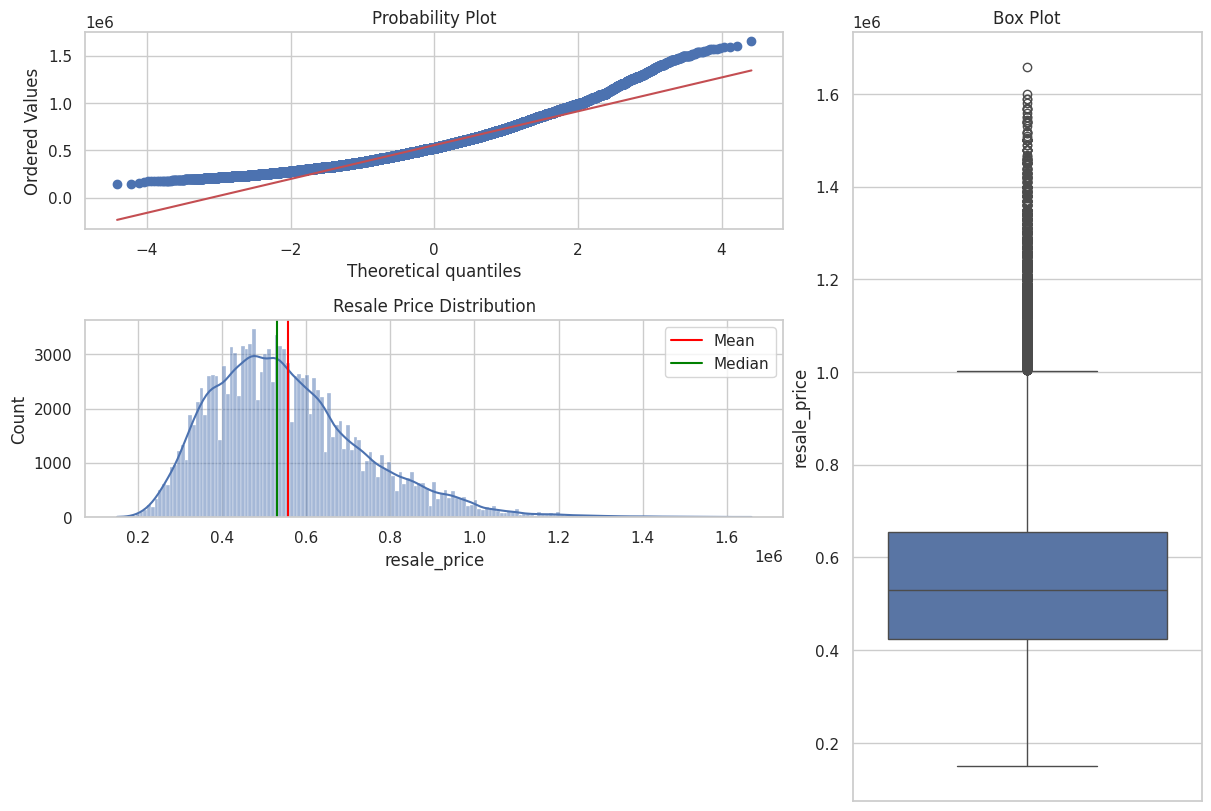

In [ ]:
def three_chart_plot(df, feature):
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    ax1 = fig.add_subplot(grid[1, :2])
    ax1.set_title('Resale Price Distribution')
    sns.histplot(df.loc[:, feature], stat="count", kde=True, ax=ax1)
    ax1.axvline(x=df[feature].mean(), color='red', label='Mean')
    ax1.axvline(x=df[feature].median(), color='green', label='Median')
    ax1.legend()

    ax2 = fig.add_subplot(grid[0, :2])
    ax2.set_title('QQ Plot')
    stats.probplot(df.loc[:, feature], plot=ax2)

    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    sns.boxplot(y=df.loc[:, feature], ax=ax3)

    plt.show()

# Example usage:
three_chart_plot(df, 'resale_price')


centralize the data.

Original Statistics:
Mean: 0.77
Std: 0.33
Min: 0.14, Max: 1.69

Min-Max Normalized Statistics:
Mean: 0.41
Std: 0.21
Min: 0.00, Max: 1.00

Z-score Normalized Statistics:
Mean: 0.00
Std: 1.00


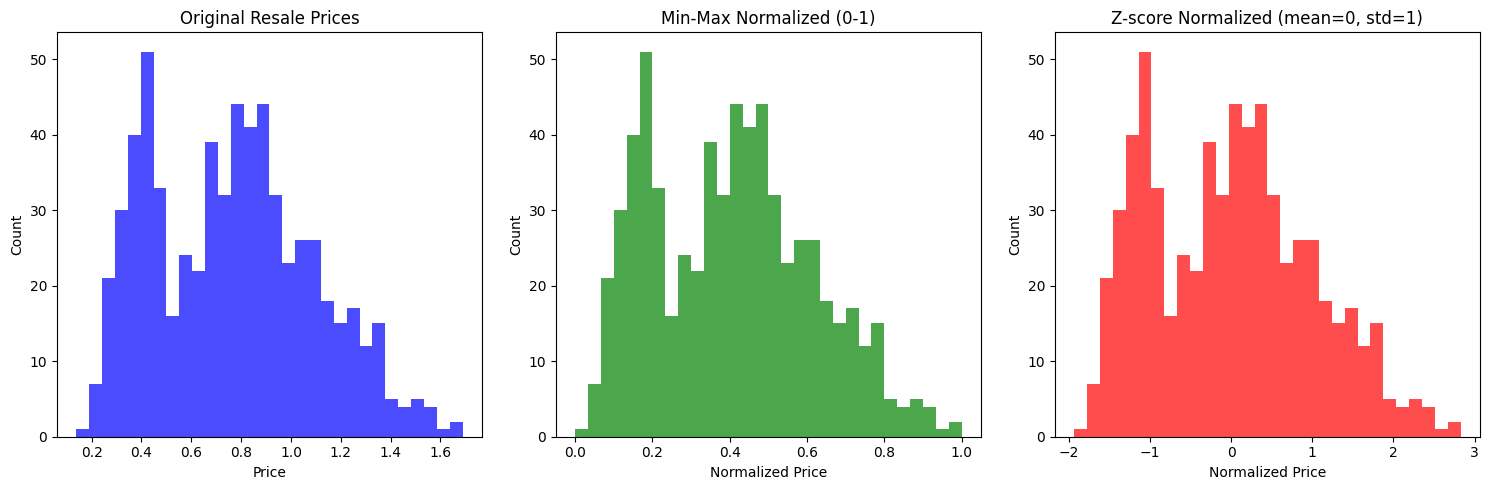


Sklearn MinMax range: 0.14 to 1.69


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Load your data (replace with your actual dataframe)
df = pd.read_csv('hdb_resale_2020_2025.csv')

# For demonstration, let's create sample data similar to your chart
np.random.seed(42)
resale_prices = np.concatenate([
    np.random.normal(0.4, 0.1, 200),
    np.random.normal(0.8, 0.15, 300),
    np.random.normal(1.2, 0.2, 150)
])

df = pd.DataFrame({'resale_price': resale_prices})

# Method 1: Min-Max Normalization (0 to 1 range)
df['min_max_normalized'] = (df['resale_price'] - df['resale_price'].min()) / (df['resale_price'].max() - df['resale_price'].min())

# Method 2: Z-score Standardization (mean=0, std=1)
df['z_score_normalized'] = (df['resale_price'] - df['resale_price'].mean()) / df['resale_price'].std()

print("Original Statistics:")
print(f"Mean: {df['resale_price'].mean():.2f}")
print(f"Std: {df['resale_price'].std():.2f}")
print(f"Min: {df['resale_price'].min():.2f}, Max: {df['resale_price'].max():.2f}")

print("\nMin-Max Normalized Statistics:")
print(f"Mean: {df['min_max_normalized'].mean():.2f}")
print(f"Std: {df['min_max_normalized'].std():.2f}")
print(f"Min: {df['min_max_normalized'].min():.2f}, Max: {df['min_max_normalized'].max():.2f}")

print("\nZ-score Normalized Statistics:")
print(f"Mean: {df['z_score_normalized'].mean():.2f}")
print(f"Std: {df['z_score_normalized'].std():.2f}")

# Plot the distributions
plt.figure(figsize=(15, 5))

# Original distribution
plt.subplot(1, 3, 1)
plt.hist(df['resale_price'], bins=30, alpha=0.7, color='blue')
plt.title('Original Resale Prices')
plt.xlabel('Price')
plt.ylabel('Count')

# Min-Max normalized
plt.subplot(1, 3, 2)
plt.hist(df['min_max_normalized'], bins=30, alpha=0.7, color='green')
plt.title('Min-Max Normalized (0-1)')
plt.xlabel('Normalized Price')
plt.ylabel('Count')

# Z-score normalized
plt.subplot(1, 3, 3)
plt.hist(df['z_score_normalized'], bins=30, alpha=0.7, color='red')
plt.title('Z-score Normalized (mean=0, std=1)')
plt.xlabel('Normalized Price')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# If you want to use sklearn for more options:
scaler = MinMaxScaler()
df['sklearn_minmax'] = scaler.fit_transform(df[['resale_price']])

print(f"\nSklearn MinMax range: {scaler.data_min_[0]:.2f} to {scaler.data_max_[0]:.2f}")

**Initial Data inspection and Handle Missing Values**

In [ ]:
# Step 3: Initial Data Inspection
print(df.head())
print(df.info())
print(df.describe(include='all'))

        month        town flat_type block        street_name storey_range  \
0  2020-06-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     07 TO 09   
1  2020-06-01  ANG MO KIO    2 ROOM   323   ANG MO KIO AVE 3     07 TO 09   
2  2020-06-01  ANG MO KIO    2 ROOM   174   ANG MO KIO AVE 4     04 TO 06   
3  2020-06-01  ANG MO KIO    2 ROOM   510   ANG MO KIO AVE 8     07 TO 09   
4  2020-06-01  ANG MO KIO    3 ROOM   225   ANG MO KIO AVE 1     10 TO 12   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979   58 years 01 month   
1            44.0        Improved                 1977  56 years 02 months   
2            45.0        Improved                 1986  64 years 08 months   
3            44.0        Improved                 1980   59 years 01 month   
4            67.0  New Generation                 1978  56 years 09 months   

   resale_price        date  
0      200000.0  2020-06-01  
1      1

In [ ]:
# Step 4: Handle Missing Values
print(df.isnull().sum())

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
date                   0
dtype: int64


**1.   Univariate Analysis** - Analyzing one variable at a time.

      *   Resale Price Distribution
      *   Distribution of floor Area
      *   Count of flat types

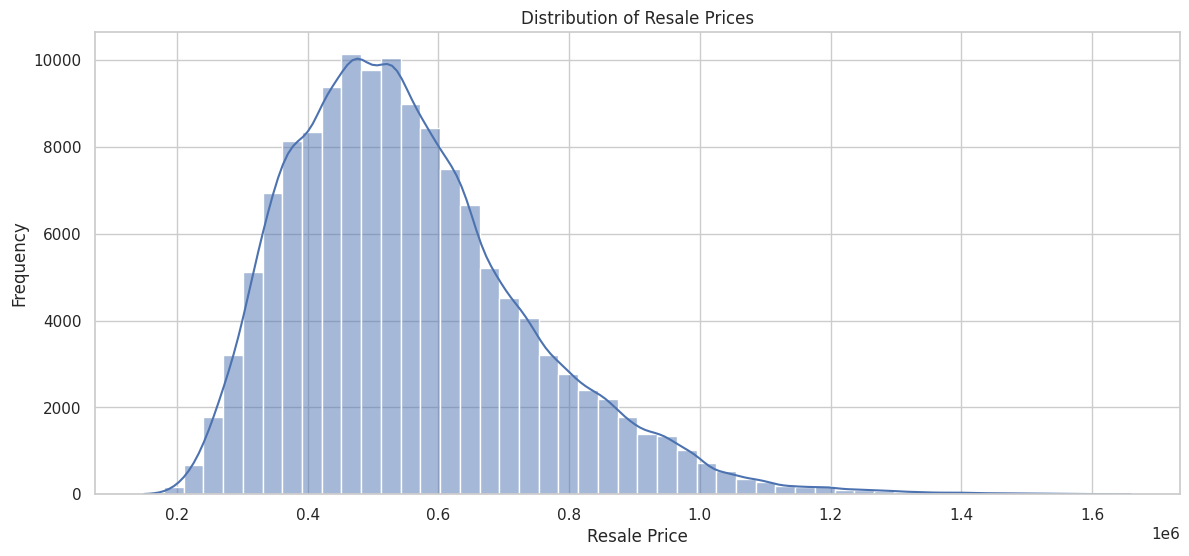

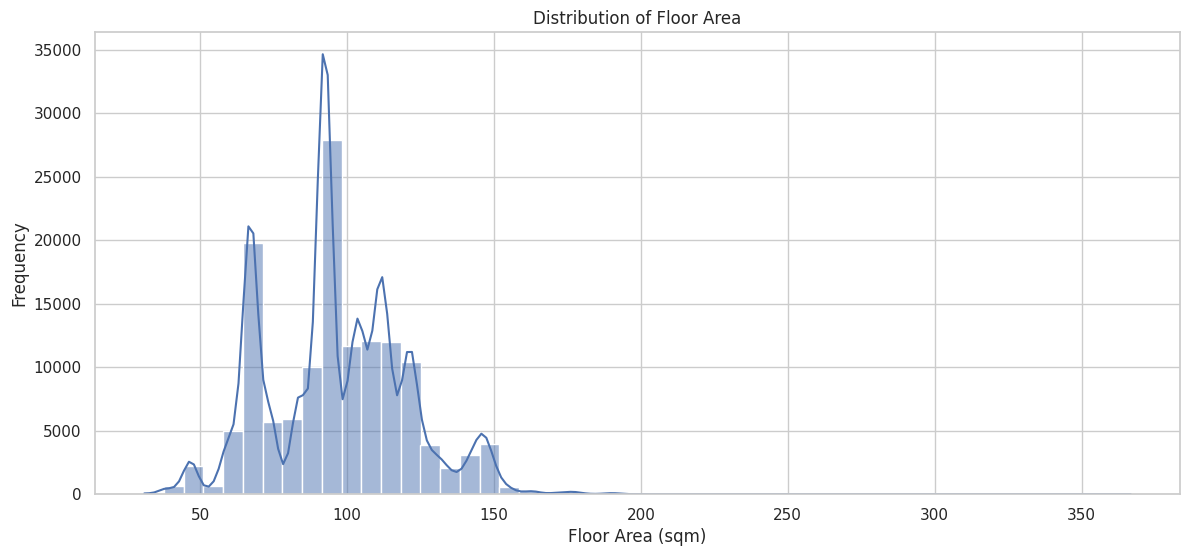

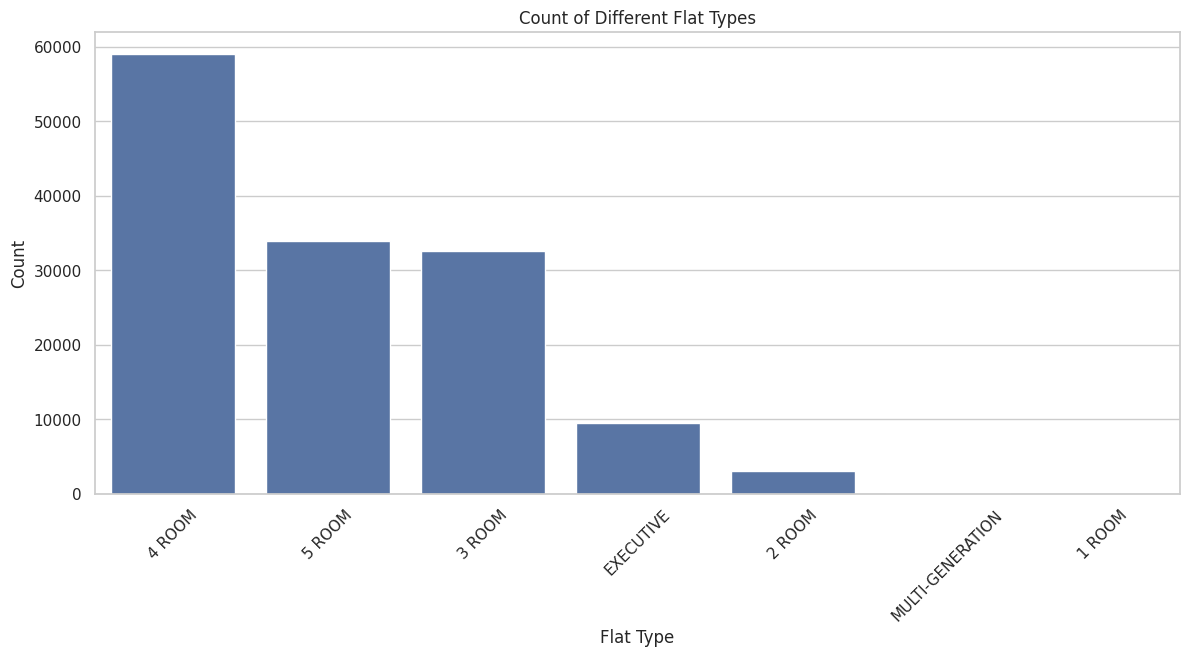

In [ ]:
# Data Visualization
sns.set(style="whitegrid")

# Plot the Resale Prices Distribution
plt.figure(figsize=(14, 6))
sns.histplot(df['resale_price'], bins=50, kde=True)
plt.title('Distribution of Resale Prices')
plt.xlabel('Resale Price')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of floor area
plt.figure(figsize=(14, 6))
sns.histplot(df['floor_area_sqm'], bins=50, kde=True)
plt.title('Distribution of Floor Area')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Frequency')
plt.show()

# Plot the count of flat types
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='flat_type', order=df['flat_type'].value_counts().index)
plt.title('Count of Different Flat Types')
plt.xlabel('Flat Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# **2.   Bivariate Analysis** - Exploring the relationship between two variables.

      *   Floor_area_sqm to Flat Type
      *   Floor Area vs Resale Price (Colored by Flat Type)
      *   Resale price by flat type (Mean, Max and Min)

/tmp/ipython-input-3483064836.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


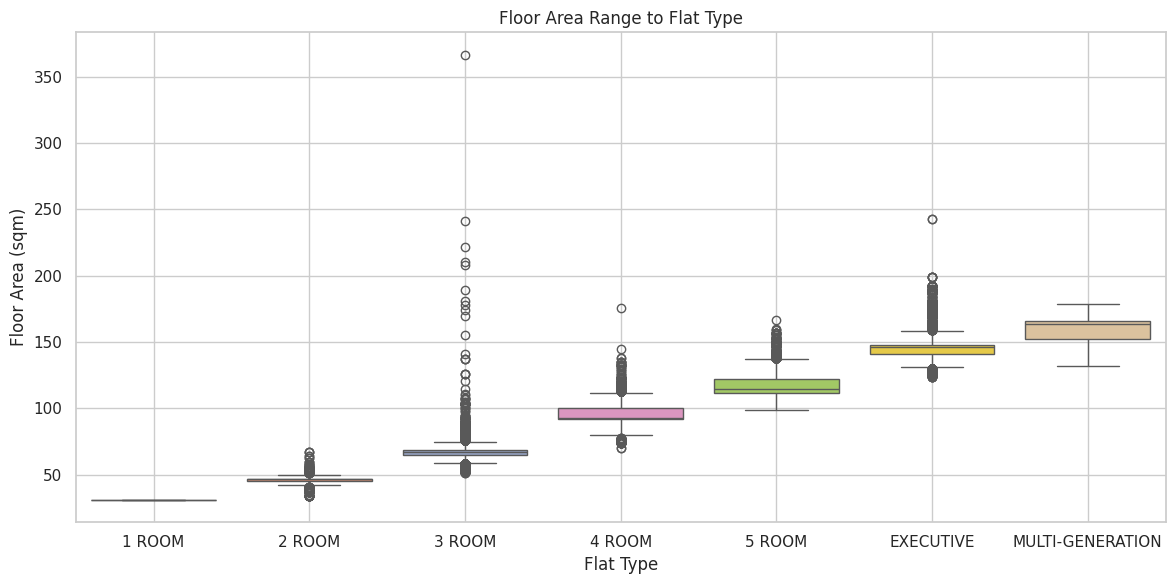

                    min    max        mean
flat_type                                 
1 ROOM             31.0   31.0   31.000000
2 ROOM             34.0   67.0   45.636636
3 ROOM             51.0  366.7   68.090861
4 ROOM             70.0  176.0   94.785671
5 ROOM             99.0  167.0  117.484317
EXECUTIVE         124.0  243.0  145.064966
MULTI-GENERATION  132.0  179.0  158.600000


/tmp/ipython-input-3483064836.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  floor_area_stats = df.groupby('flat_type')['floor_area_sqm'].agg(['min', 'max', 'mean']).reindex(flat_order)


In [ ]:
#**Floor_area_sqm to Flat Type**
#To plot the range of floor_area_sqm for each flat type in a specific order (1 ROOM, 2 ROOM, ..., MULTI-GENERATION), and show this with different colors, you can use a boxplot or violin plot using seaborn.

# Define the order explicitly
flat_order = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']

# Ensure 'flat_type' is in correct order
df['flat_type'] = pd.Categorical(df['flat_type'], categories=flat_order, ordered=True)

# Plot the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='flat_type',
    y='floor_area_sqm',
    data=df,
    order=flat_order,
    palette='Set2'
)
plt.title('Floor Area Range to Flat Type')
plt.xlabel('Flat Type')
plt.ylabel('Floor Area (sqm)')
plt.grid(True)
plt.tight_layout()
plt.show()

floor_area_stats = (
    df
    .groupby('flat_type', observed=True)['floor_area_sqm']
    .agg(['min', 'max', 'mean'])
    .reindex(flat_order)
)


floor_area_stats = df.groupby('flat_type')['floor_area_sqm'].agg(['min', 'max', 'mean']).reindex(flat_order)
print(floor_area_stats)


/tmp/ipython-input-367781409.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  floor_area_stats = df.groupby('flat_type')['floor_area_sqm'].agg(['min', 'max', 'mean']).reindex(flat_order)
/tmp/ipython-input-367781409.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(



📊 Floor Area Stats by Flat Type:
                    min    max        mean
flat_type                                 
1 ROOM             31.0   31.0   31.000000
2 ROOM             34.0   67.0   45.636636
3 ROOM             51.0  366.7   68.090861
4 ROOM             70.0  176.0   94.785671
5 ROOM             99.0  167.0  117.484317
EXECUTIVE         124.0  243.0  145.064966
MULTI-GENERATION  132.0  179.0  158.600000


/tmp/ipython-input-367781409.py:26: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipython-input-367781409.py:26: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


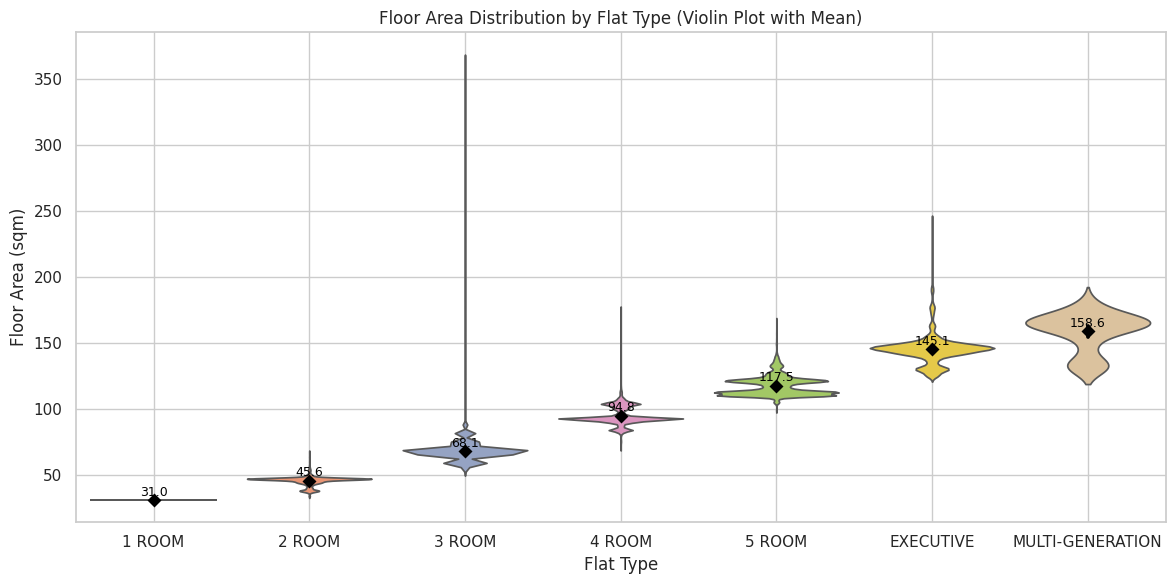

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Ensure correct flat type order
flat_order = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
df['flat_type'] = pd.Categorical(df['flat_type'], categories=flat_order, ordered=True)

# Compute floor area stats
floor_area_stats = df.groupby('flat_type')['floor_area_sqm'].agg(['min', 'max', 'mean']).reindex(flat_order)
print("\n📊 Floor Area Stats by Flat Type:")
print(floor_area_stats)

# Violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(
    x='flat_type',
    y='floor_area_sqm',
    data=df,
    order=flat_order,
    palette='Set2',
    inner=None  # We'll manually add mean points
)

# Overlay mean points
sns.pointplot(
    x='flat_type',
    y='floor_area_sqm',
    data=df,
    order=flat_order,
    estimator='mean',
    color='black',
    markers='D',
    join=False,
    scale=1
)

# Optional: Add text labels for means
means = floor_area_stats['mean']
for i, mean_val in enumerate(means):
    plt.text(i, mean_val + 1, f"{mean_val:.1f}", ha='center', va='bottom', color='black', fontsize=9)

plt.title('Floor Area Distribution by Flat Type (Violin Plot with Mean)')
plt.xlabel('Flat Type')
plt.ylabel('Floor Area (sqm)')
plt.grid(True)
plt.tight_layout()
plt.show()


**Floor Area vs Resale Price (Colored by Flat Type)**

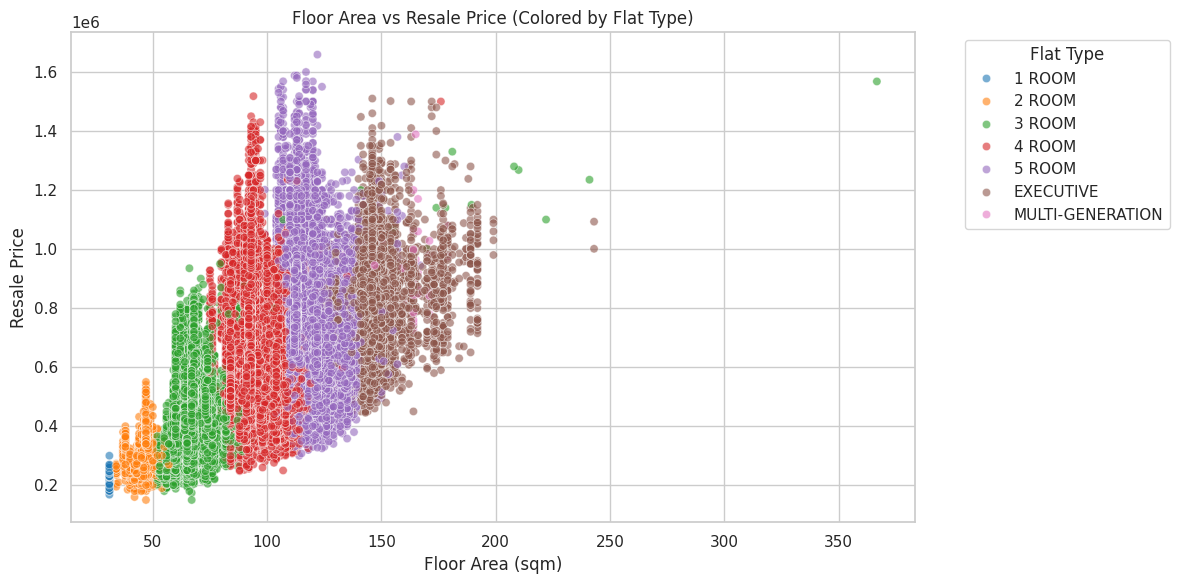

Overall Correlation between floor area and resale price: 0.61


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot with hue
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='floor_area_sqm',
    y='resale_price',
    hue='flat_type',              # Color by flat type
    data=df,
    alpha=0.6,
    palette='tab10'               # Optional: color palette
)
plt.title('Floor Area vs Resale Price (Colored by Flat Type)')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price')
plt.legend(title='Flat Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation (overall, not per flat_type)
correlation = df['floor_area_sqm'].corr(df['resale_price'])
print(f"Overall Correlation between floor area and resale price: {correlation:.2f}")


In [ ]:
# Filter for 3 ROOM flats with floor_area_sqm > 100
filtered_df = df[(df['flat_type'] == '3 ROOM') & (df['floor_area_sqm'] > 100)]

# Display the result
print(filtered_df)

# Optional: Display only selected columns
print(filtered_df[['town', 'block', 'street_name', 'floor_area_sqm', 'resale_price']])


             month             town flat_type block         street_name  \
3617    2020-07-01  KALLANG/WHAMPOA    3 ROOM    64          JLN MA'MOR   
3620    2020-07-01  KALLANG/WHAMPOA    3 ROOM    14         KG ARANG RD   
6023    2020-08-01  KALLANG/WHAMPOA    3 ROOM    55         JLN BAHAGIA   
6026    2020-08-01  KALLANG/WHAMPOA    3 ROOM    14         KG ARANG RD   
8463    2020-09-01  KALLANG/WHAMPOA    3 ROOM    55         JLN BAHAGIA   
8465    2020-09-01  KALLANG/WHAMPOA    3 ROOM    63          JLN MA'MOR   
10916   2020-10-01  KALLANG/WHAMPOA    3 ROOM    12         KG ARANG RD   
13754   2020-11-01       QUEENSTOWN    3 ROOM    50         STIRLING RD   
15138   2020-12-01     CENTRAL AREA    3 ROOM     4           SAGO LANE   
15717   2020-12-01  KALLANG/WHAMPOA    3 ROOM    53          JLN MA'MOR   
18251   2021-01-01  KALLANG/WHAMPOA    3 ROOM    64          JLN MA'MOR   
20555   2021-02-01  KALLANG/WHAMPOA    3 ROOM    14         KG ARANG RD   
21413   2021-02-01       

House that bulit in 70s and 80s. 3-room and 4 room are much bigger compare to current standard.

Here’s why Block 12 has 3‑room New Generation (NG) flats of ~103 sqm and Block 14 has 4‑room NG flats of ~123 sqm, whereas standard 3‑room flats are generally under 85 sqm:

📦 Typical Floor Area for HDB Flat Types
According to HDB and real estate sources:

3‑Room New Generation (3NG) flats from the 1980s typically range 67–88 sqm
Wikipedia
+15
DollarsAndSense.sg
+15
Reddit
+15
Reddit
+12
Reddit
+12
govtsitesquicklinks.blogspot.com
+12
.

Standard 3‑Room (3STD or 3I) typically range 53–76 sqm
DollarsAndSense.sg
+1
.

4‑Room New Generation (4NG) flats from the 1980s average around 90–95 sqm, with some Model A variants up to 105–108 sqm
HardwareZone Forums
govtsitesquicklinks.blogspot.com
.

🧱 Why Are Flats at Kampong Arang Road Larger?
1. Unique HDB Flat Model & Design
Block 12 and Block 14 at Kampong Arang Road were completed in the early 1980s (lease from 1982/84), and include NG model flats with larger layouts.

At Blk 12, resale data shows 3‑room NG flats consistently measure ~103 sqm, and 4‑room NG at ~123 sqm
DollarsAndSense.sg
+15
StackProperty
+15
StackProperty
+15
sg.propertyvow.com
+2
StackProperty
+2
.

At Blk 14, recorded floor sizes include 103 sqm, 107 sqm, 123 sqm, and 135 sqm depending on specific layout model of the unit
StackProperty
.
House that bulit in 70s and 80s. 3-room and 4 room are much bigger compare to current standard.

Here’s why Block 12 has 3‑room New Generation (NG) flats of ~103 sqm and Block 14 has 4‑room NG flats of ~123 sqm, whereas standard 3‑room flats are generally under 85 sqm:

📦 Typical Floor Area for HDB Flat Types
According to HDB and real estate sources:

3‑Room New Generation (3NG) flats from the 1980s typically range 67–88 sqm


Standard 3‑Room (3STD or 3I) typically range 53–76 sqm

4‑Room New Generation (4NG) flats from the 1980s average around 90–95 sqm, with some Model A variants up to 105–108 sqm

🧱 Why Are Flats at Kampong Arang Road Larger?
1. Unique HDB Flat Model & Design
Block 12 and Block 14 at Kampong Arang Road were completed in the early 1980s (lease from 1982/84), and include NG model flats with larger layouts.

At Blk 12, resale data shows 3‑room NG flats consistently measure ~103 sqm, and 4‑room NG at ~123 sqm

At Blk 14, recorded floor sizes include 103 sqm, 107 sqm, 123 sqm, and 135 sqm depending on specific layout model of the unit

2. Variation within “New Generation” Category
Not all NG flats are the same. While the general category includes 67–88 sqm, some NG variants have unusually larger floor areas due to design specifics or corner configurations.

For example, 3‑room NG in these blocks are at the top end (~103 sqm) — significantly larger than the standard NG range for similar vintage flats.

3. Long Lease & Island-Sized Blocks
These blocks were constructed in earlier HDB batches built on larger land parcels, allowing wider unit layouts.

Some units in Blk 14 even offer 123–135 sqm for 4‑room NG — much larger than later-year NG or Model A units
2. Variation within “New Generation” Category
Not all NG flats are the same. While the general category includes 67–88 sqm, some NG variants have unusually larger floor areas due to design specifics or corner configurations.

For example, 3‑room NG in these blocks are at the top end (~103 sqm) — significantly larger than the standard NG range for similar vintage flats.

3. Long Lease & Island-Sized Blocks
These blocks were constructed in earlier HDB batches built on larger land parcels, allowing wider unit layouts.

Some units in Blk 14 even offer 123–135 sqm for 4‑room NG — much larger than later-year NG or Model A units

| Block | Flat Type       | Floor Area (sqm) | Notes                         |
| ----- | --------------- | ---------------- | ----------------------------- |
| 12    | 3‑Room NG       | \~103            | Larger design than typical NG |
| 12    | 4‑Room NG       | \~123            | Spacious layout               |
| 14    | 3‑Room NG       | \~103, 107       | Similar to Blk 12 NG          |
| 14    | 4‑Room NG       | \~123, 135       | Bigger 4‑room variants        |
| —     | Standard 3‑Room | \~53–76          | Older or smaller design       |

**Resale Price by Flat Type**

/tmp/ipython-input-889612221.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='flat_type', y='resale_price', data=df, order=flat_order, palette='Set3')


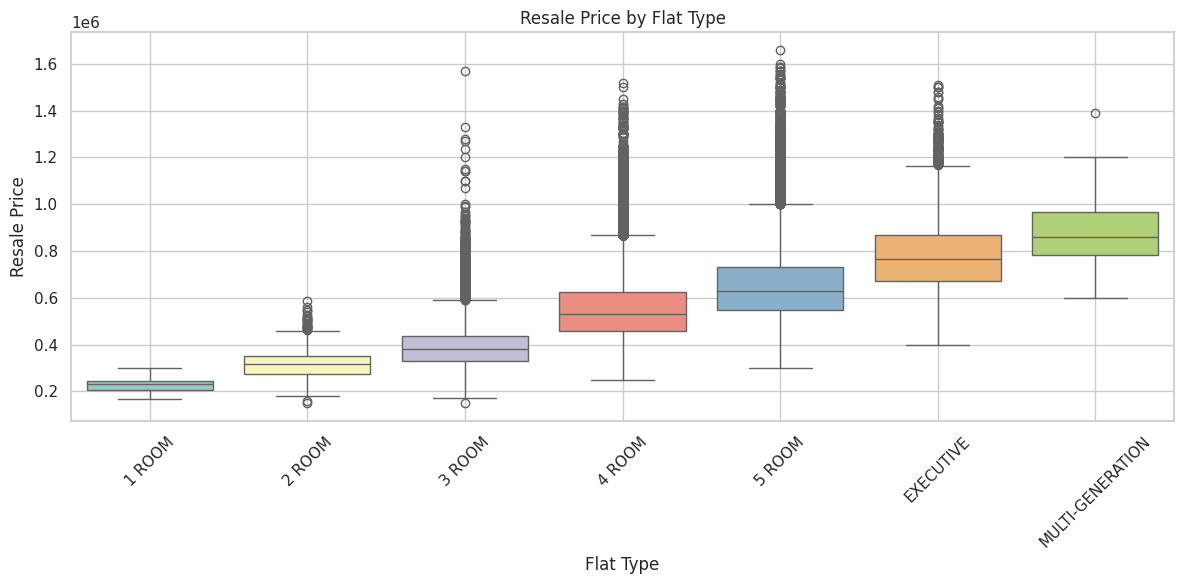


📊 Summary Statistics of Resale Price by Flat Type:
                    count           mean            std       min       25%  \
flat_type                                                                     
1 ROOM               44.0  227542.909091   29160.133478  168000.0  205000.0   
2 ROOM             3008.0  313050.628657   54132.107249  150000.0  275000.0   
3 ROOM            32595.0  395565.021616  101411.414983  150000.0  330000.0   
4 ROOM            59026.0  561747.424394  149338.201325  248000.0  460000.0   
5 ROOM            33955.0  657593.678175  161803.501450  300000.0  550000.0   
EXECUTIVE          9528.0  777062.165605  151324.791589  400000.0  670000.0   
MULTI-GENERATION     50.0  884925.520000  150334.126214  600000.0  783500.0   

                       50%       75%        max  
flat_type                                        
1 ROOM            230000.0  245500.0   300000.0  
2 ROOM            318000.0  350000.0   585000.0  
3 ROOM            380000.0  435000.0

In [ ]:
# Define the desired flat type order
flat_order = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']

# Ensure 'flat_type' is treated as an ordered categorical type
df['flat_type'] = pd.Categorical(df['flat_type'], categories=flat_order, ordered=True)

# Plot boxplot sorted by custom flat order
plt.figure(figsize=(12, 6))
sns.boxplot(x='flat_type', y='resale_price', data=df, order=flat_order, palette='Set3')
plt.title('Resale Price by Flat Type')
plt.xlabel('Flat Type')
plt.ylabel('Resale Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Summary stats sorted by flat order
print("\n📊 Summary Statistics of Resale Price by Flat Type:")
summary_stats = df.groupby('flat_type', observed=True)['resale_price'].describe().reindex(flat_order)
print(summary_stats)


# **3.   Multivariate Analysis**
      *   Flat type, town, and resale price (Multiple Method)
      *   Correlation heatmap

**Resale Price by Flat Type and Town**

**Method 1: ALL**

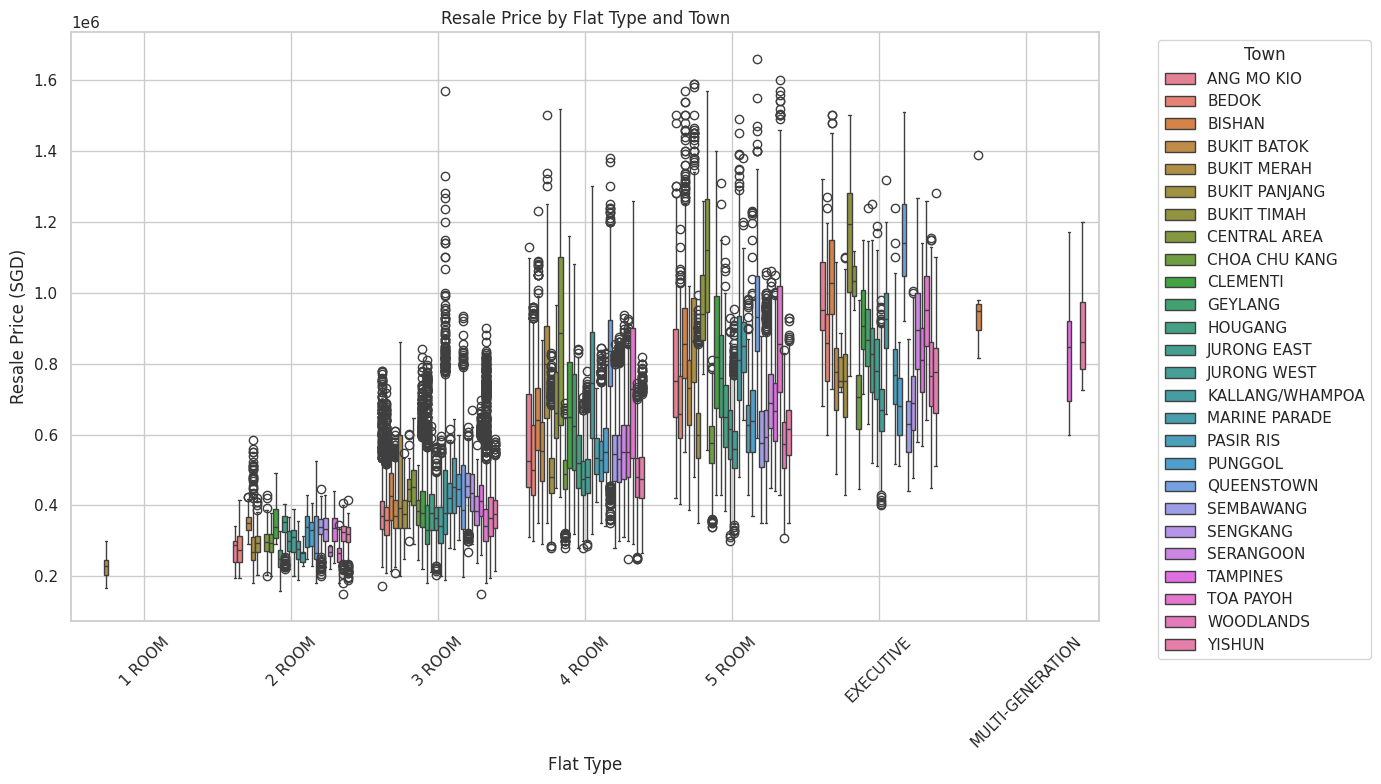

In [ ]:
#Flat type, town, and resale price
#sns.boxplot(x='flat_type', y='resale_price', hue='town', data=df)


plt.figure(figsize=(14, 8))
sns.boxplot(x='flat_type', y='resale_price', hue='town', data=df)

plt.title('Resale Price by Flat Type and Town')
plt.xlabel('Flat Type')
plt.ylabel('Resale Price (SGD)')
plt.xticks(rotation=45)
plt.legend(title='Town', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


**Method 2 : Top 5 Town**

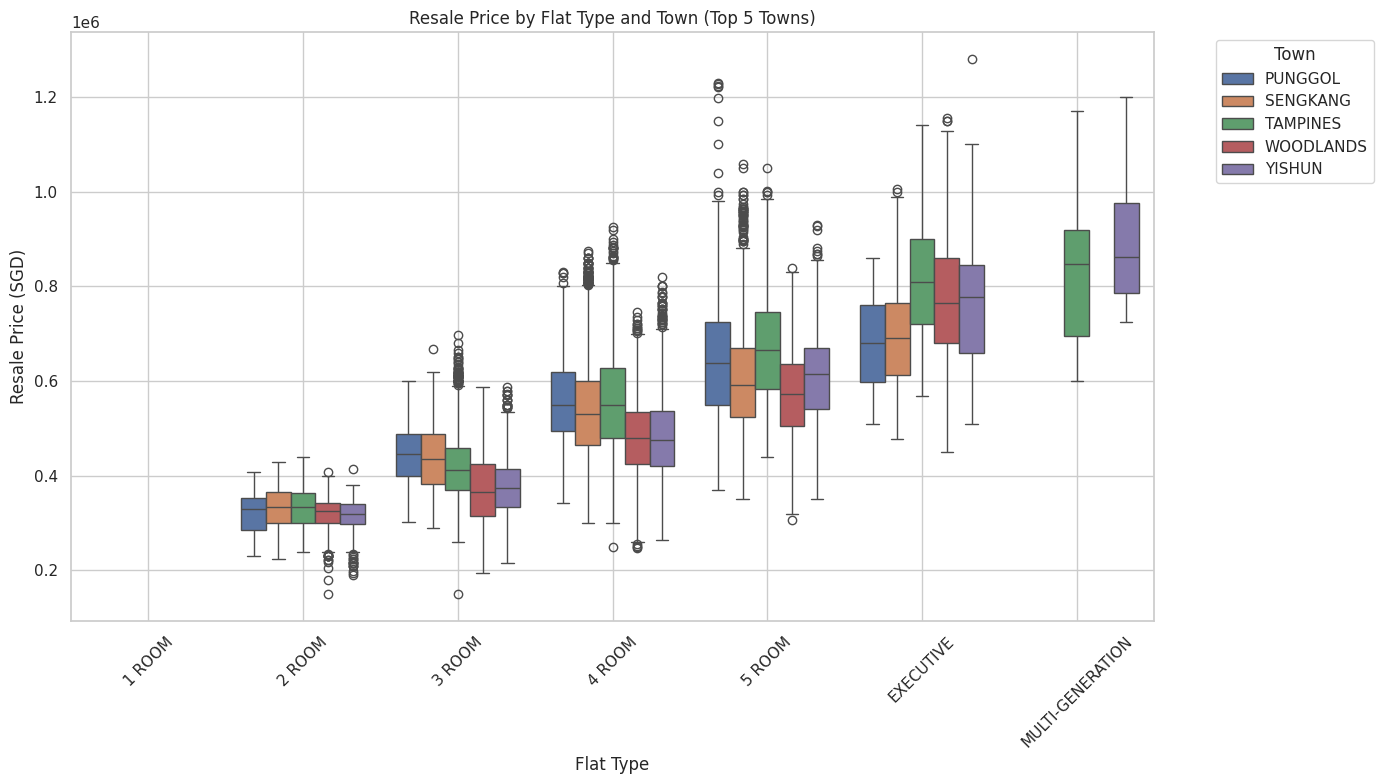

In [ ]:
# Filter top 5 towns with most entries
top_towns = df['town'].value_counts().nlargest(5).index
filtered_df = df[df['town'].isin(top_towns)]

plt.figure(figsize=(14, 8))
sns.boxplot(x='flat_type', y='resale_price', hue='town', data=filtered_df)

plt.title('Resale Price by Flat Type and Town (Top 5 Towns)')
plt.xlabel('Flat Type')
plt.ylabel('Resale Price (SGD)')
plt.xticks(rotation=45)
plt.legend(title='Town', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


**Method 3: Flat Type Per Town - Selected**

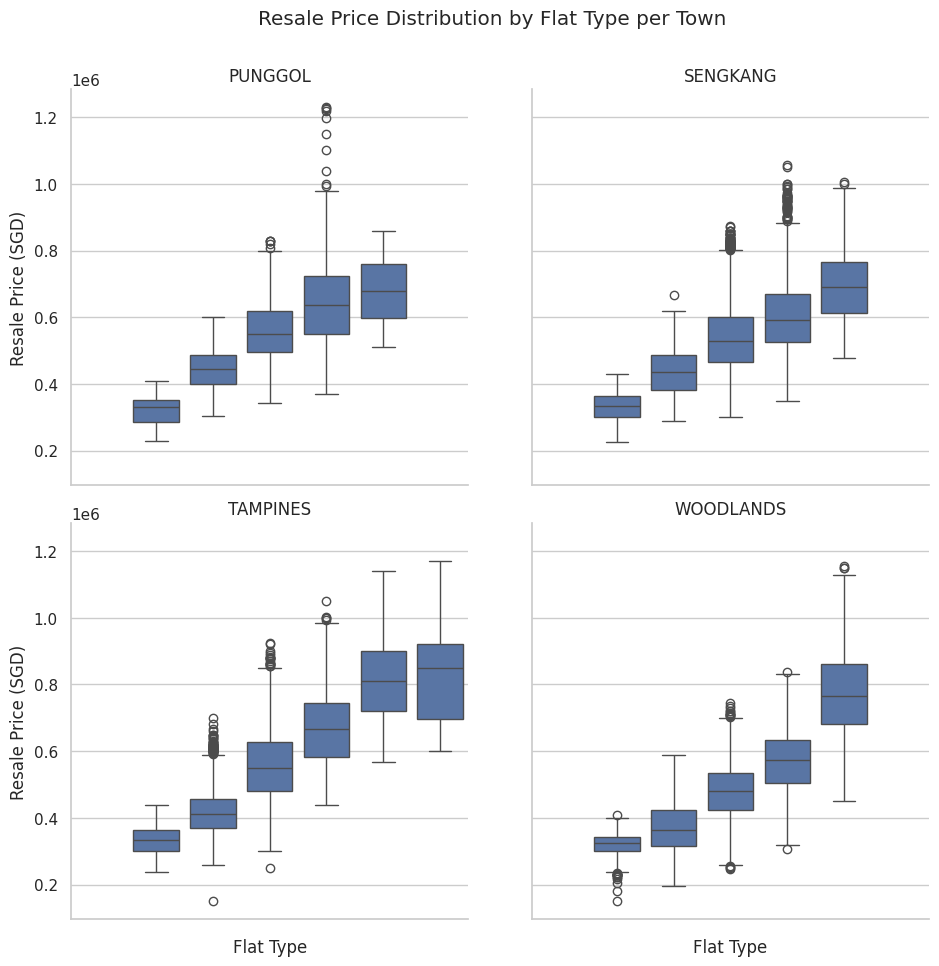

In [ ]:
# Still limit to avoid too many subplots
top_towns = df['town'].value_counts().nlargest(4).index
filtered_df = df[df['town'].isin(top_towns)]

g = sns.FacetGrid(filtered_df, col="town", col_wrap=2, height=5)
g.map(sns.boxplot, "flat_type", "resale_price", order=sorted(df['flat_type'].unique()))
g.set_xticklabels(rotation=45)
g.set_titles("{col_name}")
g.set_axis_labels("Flat Type", "Resale Price (SGD)")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Resale Price Distribution by Flat Type per Town')
plt.show()


**Method 4: Plotly**

In [ ]:
import pandas as pd
import plotly.express as px

# Step 1: Define your flat type order
flat_order = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']

# Step 2: Convert flat_type to an ordered categorical column
df['flat_type'] = pd.Categorical(df['flat_type'], categories=flat_order, ordered=True)

# Step 3: Plot the boxplot using Plotly Express
fig = px.box(df,
             x="flat_type",
             y="resale_price",
             color="town",
             title="Resale Price by Flat Type and Town",
             labels={"resale_price": "Resale Price (SGD)", "flat_type": "Flat Type"},
             category_orders={"flat_type": flat_order}  # <-- Force order here too
)

# Optional: Rotate labels for readability
fig.update_layout(xaxis_tickangle=-45)
fig.show()

**Correlation heatmap**

**Method : Plotly**

In [ ]:
import plotly.graph_objects as go

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='RdBu',  # similar to 'coolwarm'
    zmin=-1, zmax=1,
    colorbar=dict(title="Correlation Coefficient")
))

fig.update_layout(
    title="Correlation Heatmap",
    xaxis_title="Features",
    yaxis_title="Features",
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

fig.show()


**Method: Seaborn**

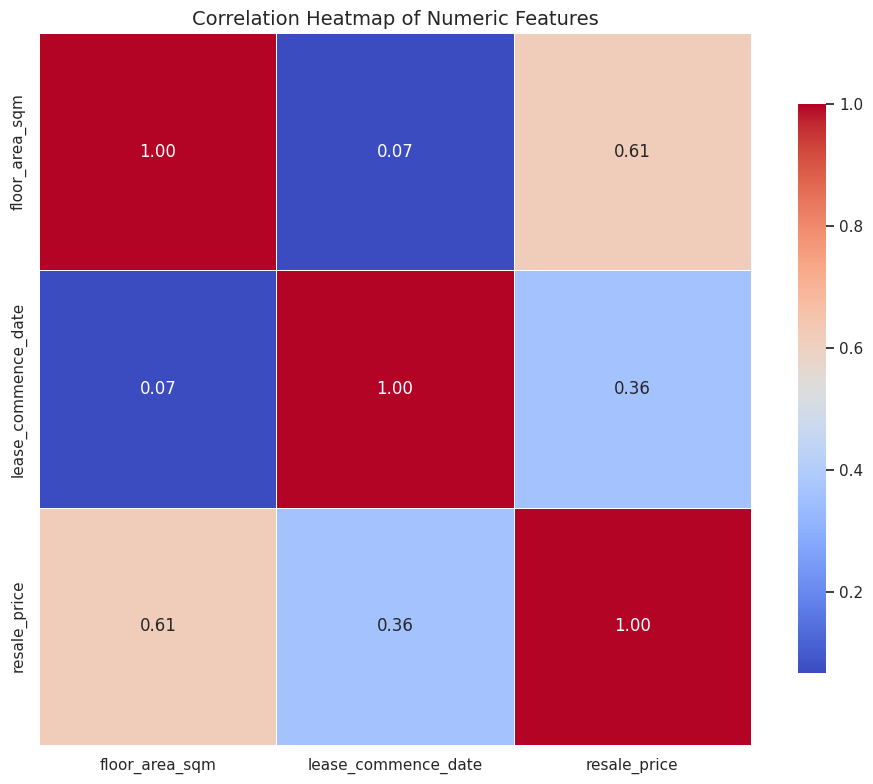

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix for numeric columns only
corr_matrix = df.corr(numeric_only=True)

# Set figure size
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})

# Title
plt.title('Correlation Heatmap of Numeric Features', fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()


# **4. Time Series Analysis** - If your dataset includes month/year information.

    *   Trend of resale price over time


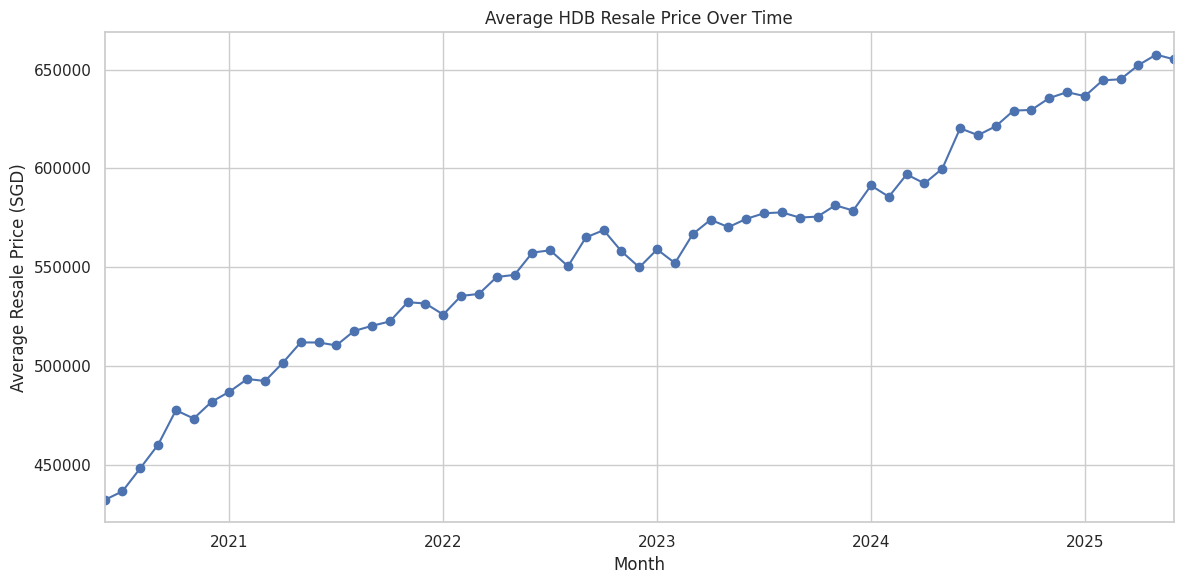

In [ ]:
# Ensure 'month' column is datetime type for proper sorting
df['month'] = pd.to_datetime(df['month'])

# Group by month and calculate mean resale price, then plot
df.groupby('month')['resale_price'].mean().plot(figsize=(12, 6), marker='o')

plt.title('Average HDB Resale Price Over Time')
plt.xlabel('Month')
plt.ylabel('Average Resale Price (SGD)')
plt.grid(True)
plt.tight_layout()
plt.show()

# **5.   Outlier Detection**

    *   Detecting unusually high resale prices

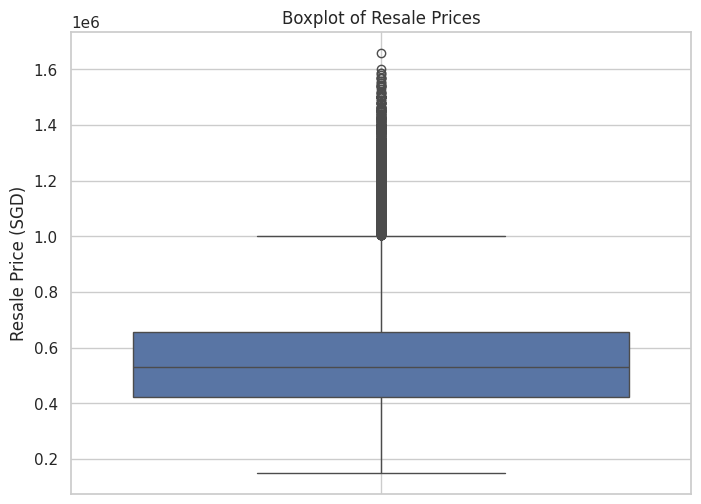

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['resale_price'])
plt.title('Boxplot of Resale Prices')
plt.ylabel('Resale Price (SGD)')
plt.grid(True)
plt.show()

# HDB Resale Price Prediction: Complete Model Training & Comparison

**Author:** Machine Learning Team  
**Project Phase:** Model Training & Evaluation  

## 🎯 **Complete Model Training Pipeline**

### **Three Model Categories Implementation:**

#### **1. 📈 Linear Models**
- **Linear Regression** (Baseline)
- **Ridge Regression** (L2 Regularization)
- **Lasso Regression** (L1 Regularization)
- **Elastic Net** (L1 + L2 Regularization)

#### **2. 🌳 Tree-Based Models**
- **Decision Tree** (Single tree)
- **Random Forest** (Ensemble of trees)
- **Extra Trees** (Extremely randomized trees)

#### **3. 🚀 Boosting Models**
- **Gradient Boosting** (Scikit-learn)
- **XGBoost** (Extreme Gradient Boosting)
- **LightGBM** (Light Gradient Boosting)
- **CatBoost** (Categorical Boosting)

##   **4. 📊 Comprehensive Evaluation & Comparison**

- **Performance Metrics:** R², RMSE, MAE, MAPE
- **Cross-Validation:** Temporal-aware validation
- **Hyperparameter Tuning:** Grid Search & Random Search
- **Feature Importance Analysis**
- **Model Comparison Dashboard**
- **Final Model Recommendation**

##   **5. Final Model Selection & Recommendations**

- **Model Selection Criteria and Final Recommendation**

##   **6. Ensemble Method**


## 0. Model Training Environment Setup

### 0.1 Machine Learning Libraries and Configuration

In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


**0.2 Core Libraries**

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# **0.3 Load file and data processing**

In [ ]:
# Load the dataset
#file_path = 'base_hdb_resale_prices_2015Jan-2025Jun_processed.csv'
#file_path = '/content/base_hdb_resale_prices_2015Jan-2025Jun.csv'
#df = pd.read_csv(file_path)

# Function to convert 'remaining_lease' to float years
def convert_lease_to_years(lease_str):
    if not isinstance(lease_str, str):
        return lease_str  # keep original if not a string

    lease_str = lease_str.strip().lower()

    # Skip plain numeric values like "70"
    if re.fullmatch(r'\d+', lease_str):
        return lease_str

    # Extract years and months using regex
    year_match = re.search(r'(\d+)\s*year', lease_str)
    month_match = re.search(r'(\d+)\s*month', lease_str)

    years = int(year_match.group(1)) if year_match else 0
    months = int(month_match.group(1)) if month_match else 0

    return round(years + months / 12, 3)

# Replace the original 'remaining_lease' column with converted values
df['remaining_lease'] = df['remaining_lease'].apply(convert_lease_to_years)


# Save the updated DataFrame to a new CSV
df.to_csv('base_hdb_resale_prices_2015Jan-2025Jun_processed.csv', index=False)

print("Conversion complete. Original 'remaining_lease' field has been updated.")

Conversion complete. Original 'remaining_lease' field has been updated.


In [ ]:
df.shape

(138206, 12)

In [ ]:
df.head()

month        town flat_type block        street_name storey_range  \
0 2020-06-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     07 TO 09   
1 2020-06-01  ANG MO KIO    2 ROOM   323   ANG MO KIO AVE 3     07 TO 09   
2 2020-06-01  ANG MO KIO    2 ROOM   174   ANG MO KIO AVE 4     04 TO 06   
3 2020-06-01  ANG MO KIO    2 ROOM   510   ANG MO KIO AVE 8     07 TO 09   
4 2020-06-01  ANG MO KIO    3 ROOM   225   ANG MO KIO AVE 1     10 TO 12   

   floor_area_sqm      flat_model  lease_commence_date  remaining_lease  \
0            44.0        Improved                 1979           58.083   
1            44.0        Improved                 1977           56.167   
2            45.0        Improved                 1986           64.667   
3            44.0        Improved                 1980           59.083   
4            67.0  New Generation                 1978           56.750   

   resale_price        date  
0      200000.0  2020-06-01  
1      196000.0  2020-06-01  
2      205000.0  2020-06-01  
3      199000.0  2020-06-01  
4      300000.0  2020-06-01

# **1. 📈 Linear Models | 2. 🌳 Tree-Based Models | 3. 🚀 Boosting Models**

In [ ]:
# Machine Learning - Linear Models
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    RidgeCV, LassoCV, ElasticNetCV
)

# Machine Learning - Tree Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor
)

# Advanced Boosting Models
try:
    import xgboost as xgb
    print("✓ XGBoost available")
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠ XGBoost not available (install: pip install xgboost)")
    XGBOOST_AVAILABLE = False

try:
    import lightgbm as lgb
    print("✓ LightGBM available")
    LIGHTGBM_AVAILABLE = True
except ImportError:
    print("⚠ LightGBM not available (install: pip install lightgbm)")
    LIGHTGBM_AVAILABLE = False

try:
    import catboost as cb
    print("✓ CatBoost available")
    CATBOOST_AVAILABLE = True
except ImportError:
    print("⚠ CatBoost not available (install: pip install catboost)")
    CATBOOST_AVAILABLE = False

# Model Evaluation and Optimization
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV,
    RandomizedSearchCV, KFold, TimeSeriesSplit
)
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error
)
from sklearn.preprocessing import StandardScaler

# Utilities
import time
import joblib
from collections import defaultdict

print("\n🚀 Complete Model Training Environment Ready!")
print(f"Linear Models: ✓ Available (4 models)")
print(f"Tree Models: ✓ Available (3 models)")
print(f"Boosting Models: {'✓ Full Suite (4 models)' if all([XGBOOST_AVAILABLE, LIGHTGBM_AVAILABLE, CATBOOST_AVAILABLE]) else '⚠ Partial Suite'}")

✓ XGBoost available
✓ LightGBM available
✓ CatBoost available

🚀 Complete Model Training Environment Ready!
Linear Models: ✓ Available (4 models)
Tree Models: ✓ Available (3 models)
Boosting Models: ✓ Full Suite (4 models)


In [ ]:
# Model training configuration
MODEL_CONFIG = {
    'random_state': 42,
    'cv_folds': 5,
    'scoring': 'r2',
    'n_jobs': -1
}

# Performance targets
PERFORMANCE_TARGETS = {
    'linear_models': {'r2': 0.80, 'rmse': 50000},
    'tree_models': {'r2': 0.85, 'rmse': 45000},
    'boosting_models': {'r2': 0.90, 'rmse': 40000}
}

# Visualization setup
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")
np.random.seed(42)

print("Configuration loaded successfully!")

Configuration loaded successfully!


In [ ]:
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    """Comprehensive model evaluation with multiple metrics."""
    start_time = time.time()
    #model.fit(X_train, y_train)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=50, # Set a reasonable number of rounds
              verbose=False)


    training_time = time.time() - start_time

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    return {
        'model_name': model_name,
        'training_time': training_time,
        'train_r2': r2_score(y_train, y_train_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'val_r2': r2_score(y_val, y_val_pred),
        'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'val_mape': mean_absolute_percentage_error(y_val, y_val_pred) * 100,
        'overfitting': r2_score(y_train, y_train_pred) - r2_score(y_val, y_val_pred),
        'model': model,
        'predictions': {'y_val_pred': y_val_pred}
    }

def plot_model_comparison(results_list):
    """Create comprehensive model comparison plots."""
    # Extract data for plotting
    models = [r['model_name'] for r in results_list]
    r2_scores = [r['val_r2'] for r in results_list]
    rmse_scores = [r['val_rmse'] for r in results_list]
    training_times = [r['training_time'] for r in results_list]

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # R² comparison
    axes[0,0].bar(models, r2_scores, color='skyblue', alpha=0.7)
    axes[0,0].set_title('Model Comparison - R² Score')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)

    # RMSE comparison
    axes[0,1].bar(models, rmse_scores, color='lightcoral', alpha=0.7)
    axes[0,1].set_title('Model Comparison - RMSE')
    axes[0,1].set_ylabel('RMSE ($)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)

    # Training time comparison
    axes[1,0].bar(models, training_times, color='lightgreen', alpha=0.7)
    axes[1,0].set_title('Model Comparison - Training Time')
    axes[1,0].set_ylabel('Training Time (seconds)')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)

    # Performance vs Speed scatter
    axes[1,1].scatter(training_times, r2_scores, s=100, alpha=0.7)
    for i, model in enumerate(models):
        axes[1,1].annotate(model, (training_times[i], r2_scores[i]),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1,1].set_xlabel('Training Time (seconds)')
    axes[1,1].set_ylabel('R² Score')
    axes[1,1].set_title('Performance vs Training Speed')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def create_results_table(results_list):
    """Create formatted results table."""
    data = []
    for r in results_list:
        data.append({
            'Model': r['model_name'],
            'Val R²': f"{r['val_r2']:.4f}",
            'Val RMSE': f"${r['val_rmse']:,.0f}",
            'Val MAE': f"${r['val_mae']:,.0f}",
            'Val MAPE': f"{r['val_mape']:.2f}%",
            'Overfitting': f"{r['overfitting']:.4f}",
            'Time (s)': f"{r['training_time']:.2f}"
        })
    return pd.DataFrame(data)

print("Utility functions loaded!")

Utility functions loaded!


## Load Preprocessed Data

**Note:** This assumes you have preprocessed data ready. If not, basic preprocessing is included as fallback.

In [ ]:
# Load preprocessed data
print("LOADING DATA FOR MODEL TRAINING")
print("=" * 50)

try:
    # Try to load preprocessed data
    X_train = pd.read_csv('X_train.csv')
    X_val = pd.read_csv('X_val.csv')
    X_test = pd.read_csv('X_test.csv')
    y_train = pd.read_csv('y_train.csv').squeeze()
    y_val = pd.read_csv('y_val.csv').squeeze()
    y_test = pd.read_csv('y_test.csv').squeeze()
    print("✓ Loaded preprocessed data from files")

except FileNotFoundError:
    print("⚠ Preprocessed files not found. Applying basic preprocessing...")

    # Load and preprocess data
    df = pd.read_csv('base_hdb_resale_prices_2015Jan-2025Jun_processed.csv')
    #df = pd.read_csv('base_hdb_resale_prices_2015Jan-2025Jun.csv')
    print(f"Loaded raw data: {df.shape}")

    # Basic preprocessing
    df = df.dropna()
    df['month'] = pd.to_datetime(df['month'])
    df['transaction_year'] = df['month'].dt.year
    df['transaction_month'] = df['month'].dt.month

    # Simple encoding
    from sklearn.preprocessing import LabelEncoder
    categorical_cols = ['town', 'flat_type', 'flat_model', 'storey_range']

    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    # Prepare features and target
    target_col = 'resale_price'
    feature_cols = [col for col in df.columns if col not in [target_col, 'month', 'block', 'street_name']]

    X = df[feature_cols]
    y = df[target_col]

    # Temporal split
    df_sorted = df.sort_values('month')
    n_total = len(df_sorted)
    n_test = int(n_total * 0.2)
    n_val = int((n_total - n_test) * 0.2)
    n_train = n_total - n_test - n_val

    X_train = X.iloc[:n_train]
    X_val = X.iloc[n_train:n_train + n_val]
    X_test = X.iloc[n_train + n_val:]

    y_train = y.iloc[:n_train]
    y_val = y.iloc[n_train:n_train + n_val]
    y_test = y.iloc[n_train + n_val:]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    print("✓ Basic preprocessing completed")

# Display data info
print(f"\n📊 Dataset Ready:")
print(f"Training: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Validation: {X_val.shape[0]:,} samples")
print(f"Test: {X_test.shape[0]:,} samples")
print(f"Target range: ${y_train.min():,.0f} - ${y_train.max():,.0f}")
print(f"\n✅ Ready for model training!")

LOADING DATA FOR MODEL TRAINING
⚠ Preprocessed files not found. Applying basic preprocessing...
Loaded raw data: (138206, 12)


ValueError: could not convert string to float: '2020-06-01'

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load preprocessed data
print("LOADING DATA FOR MODEL TRAINING")
print("=" * 50)

try:
    # Try to load preprocessed data
    X_train = pd.read_csv('X_train.csv')
    X_val = pd.read_csv('X_val.csv')
    X_test = pd.read_csv('X_test.csv')
    y_train = pd.read_csv('y_train.csv').squeeze()
    y_val = pd.read_csv('y_val.csv').squeeze()
    y_test = pd.read_csv('y_test.csv').squeeze()
    print("✓ Loaded preprocessed data from files")

except FileNotFoundError:
    print("⚠ Preprocessed files not found. Applying basic preprocessing...")

    # Load and preprocess data
    df = pd.read_csv('base_hdb_resale_prices_2015Jan-2025Jun_processed.csv')
    print(f"Loaded raw data: {df.shape}")

    # Basic preprocessing
    df = df.dropna()

    # Convert month to datetime and extract features
    df['month'] = pd.to_datetime(df['month'])
    df['transaction_year'] = df['month'].dt.year
    df['transaction_month'] = df['month'].dt.month
    df['transaction_quarter'] = df['month'].dt.quarter

    # Remove date columns before scaling
    columns_to_remove = ['month', 'block', 'street_name']
    df = df.drop(columns=[col for col in columns_to_remove if col in df.columns])

    # Simple encoding for categorical variables
    categorical_cols = ['town', 'flat_type', 'flat_model', 'storey_range']
    categorical_cols = [col for col in categorical_cols if col in df.columns]

    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

    # Prepare features and target
    target_col = 'resale_price'
    feature_cols = [col for col in df.columns if col != target_col]

    X = df[feature_cols]
    y = df[target_col]

    # Temporal split (sort by year and month for time series)
    df_sorted = df.sort_values(['transaction_year', 'transaction_month'])
    n_total = len(df_sorted)
    n_test = int(n_total * 0.2)
    n_val = int(n_total * 0.15)
    n_train = n_total - n_test - n_val

    X_train = X.iloc[:n_train]
    X_val = X.iloc[n_train:n_train + n_val]
    X_test = X.iloc[n_train + n_val:]

    y_train = y.iloc[:n_train]
    y_val = y.iloc[n_train:n_train + n_val]
    y_test = y.iloc[n_train + n_val:]

    # Scale only numerical features (excluding encoded categoricals)
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
    numerical_cols = [col for col in numerical_cols if col not in categorical_cols]

    scaler = StandardScaler()

    # Scale numerical features only
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_cols])
    X_val_num_scaled = scaler.transform(X_val[numerical_cols])
    X_test_num_scaled = scaler.transform(X_test[numerical_cols])

    # Combine scaled numerical features with categorical features
    X_train_scaled = pd.DataFrame(
        X_train_num_scaled,
        columns=numerical_cols,
        index=X_train.index
    )
    X_val_scaled = pd.DataFrame(
        X_val_num_scaled,
        columns=numerical_cols,
        index=X_val.index
    )
    X_test_scaled = pd.DataFrame(
        X_test_num_scaled,
        columns=numerical_cols,
        index=X_test.index
    )

    # Add back categorical features
    for col in categorical_cols:
        X_train_scaled[col] = X_train[col].values
        X_val_scaled[col] = X_val[col].values
        X_test_scaled[col] = X_test[col].values

    X_train = X_train_scaled
    X_val = X_val_scaled
    X_test = X_test_scaled

    print("✓ Basic preprocessing completed")

# Display data info
print(f"\n📊 Dataset Ready:")
print(f"Training: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Validation: {X_val.shape[0]:,} samples")
print(f"Test: {X_test.shape[0]:,} samples")
print(f"Target range: ${y_train.min():,.0f} - ${y_train.max():,.0f}")
print(f"\n✅ Ready for model training!")

LOADING DATA FOR MODEL TRAINING
⚠ Preprocessed files not found. Applying basic preprocessing...
Loaded raw data: (138206, 12)
✓ Basic preprocessing completed

📊 Dataset Ready:
Training: 89,835 samples, 7 features
Validation: 20,730 samples
Test: 27,641 samples
Target range: $160,000 - $1,500,000

✅ Ready for model training!


## 1. Linear Models Training & Evaluation

### 1.1 Linear Regression Family

Training baseline linear models with different regularization techniques.

In [ ]:
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    """Comprehensive model evaluation with multiple metrics."""
    start_time = time.time()

    # Conditionally add early stopping parameters for models that support them
    try:
        # This will work for XGBoost, LightGBM, and GradientBoostingRegressor
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=50,
                  verbose=False)
    except TypeError:
        # Fallback for models that do not support eval_set (e.g., Linear Regression)
        model.fit(X_train, y_train)

    training_time = time.time() - start_time

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    return {
        'model_name': model_name,
        'training_time': training_time,
        'train_r2': r2_score(y_train, y_train_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'val_r2': r2_score(y_val, y_val_pred),
        'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'val_mape': mean_absolute_percentage_error(y_val, y_val_pred) * 100,
        'overfitting': r2_score(y_train, y_train_pred) - r2_score(y_val, y_val_pred),
        'model': model,
        'predictions': {'y_val_pred': y_val_pred}
    }

In [ ]:
# Linear Models Training
print("📈 LINEAR MODELS TRAINING")
print("=" * 50)

linear_results = []

# 1. Linear Regression (Baseline)
print("\n1. Training Linear Regression (Baseline)...")
lr = LinearRegression()
lr_result = evaluate_model(lr, X_train, X_val, y_train, y_val, "Linear Regression")
linear_results.append(lr_result)
print(f"   R²: {lr_result['val_r2']:.4f}, RMSE: ${lr_result['val_rmse']:,.0f}")

# 2. Ridge Regression (L2 Regularization)
print("\n2. Training Ridge Regression...")
ridge = Ridge(alpha=1.0, random_state=42)
ridge_result = evaluate_model(ridge, X_train, X_val, y_train, y_val, "Ridge Regression")
linear_results.append(ridge_result)
print(f"   R²: {ridge_result['val_r2']:.4f}, RMSE: ${ridge_result['val_rmse']:,.0f}")

# 3. Lasso Regression (L1 Regularization)
print("\n3. Training Lasso Regression...")
lasso = Lasso(alpha=1.0, random_state=42, max_iter=2000)
lasso_result = evaluate_model(lasso, X_train, X_val, y_train, y_val, "Lasso Regression")
linear_results.append(lasso_result)
print(f"   R²: {lasso_result['val_r2']:.4f}, RMSE: ${lasso_result['val_rmse']:,.0f}")

# 4. Elastic Net (L1 + L2 Regularization)
print("\n4. Training Elastic Net...")
elastic = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42, max_iter=2000)
elastic_result = evaluate_model(elastic, X_train, X_val, y_train, y_val, "Elastic Net")
linear_results.append(elastic_result)
print(f"   R²: {elastic_result['val_r2']:.4f}, RMSE: ${elastic_result['val_rmse']:,.0f}")

# Linear Models Summary
print(f"\n📊 LINEAR MODELS SUMMARY:")
print("-" * 50)
linear_df = create_results_table(linear_results)
print(linear_df.to_string(index=False))

# Best linear model
best_linear = max(linear_results, key=lambda x: x['val_r2'])
print(f"\n🏆 Best Linear Model: {best_linear['model_name']}")
print(f"   Validation R²: {best_linear['val_r2']:.4f}")
print(f"   Target R² (Linear): {PERFORMANCE_TARGETS['linear_models']['r2']:.2f}")
print(f"   Status: {'✅ Target Achieved' if best_linear['val_r2'] >= PERFORMANCE_TARGETS['linear_models']['r2'] else '⚠ Below Target'}")

📈 LINEAR MODELS TRAINING

1. Training Linear Regression (Baseline)...
   R²: 0.6836, RMSE: $105,113

2. Training Ridge Regression...
   R²: 0.6839, RMSE: $105,067

3. Training Lasso Regression...
   R²: 0.6836, RMSE: $105,105

4. Training Elastic Net...
   R²: 0.4866, RMSE: $133,895

📊 LINEAR MODELS SUMMARY:
--------------------------------------------------
            Model Val R² Val RMSE Val MAE Val MAPE Overfitting Time (s)
Linear Regression 0.6836 $105,113 $78,081   13.28%     -0.0200     0.05
 Ridge Regression 0.6839 $105,067 $77,945   13.25%     -0.0203     0.01
 Lasso Regression 0.6836 $105,105 $78,058   13.27%     -0.0200     3.57
      Elastic Net 0.4866 $133,895 $87,662   12.99%      0.0944     0.46

🏆 Best Linear Model: Ridge Regression
   Validation R²: 0.6839
   Target R² (Linear): 0.80
   Status: ⚠ Below Target


## 2. Tree-Based Models Training & Evaluation

### 2.1 Decision Trees and Ensemble Methods

Training tree-based models to capture non-linear patterns and feature interactions.

In [ ]:
# Tree-Based Models Training
print("🌳 TREE-BASED MODELS TRAINING")
print("=" * 50)

tree_results = []

# 1. Decision Tree
print("\n1. Training Decision Tree...")
dt = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=20)
dt_result = evaluate_model(dt, X_train, X_val, y_train, y_val, "Decision Tree")
tree_results.append(dt_result)
print(f"   R²: {dt_result['val_r2']:.4f}, RMSE: ${dt_result['val_rmse']:,.0f}")

# 2. Random Forest
print("\n2. Training Random Forest...")
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=15,
    min_samples_split=10,
    n_jobs=-1
)
rf_result = evaluate_model(rf, X_train, X_val, y_train, y_val, "Random Forest")
tree_results.append(rf_result)
print(f"   R²: {rf_result['val_r2']:.4f}, RMSE: ${rf_result['val_rmse']:,.0f}")

# 3. Extra Trees
print("\n3. Training Extra Trees...")
et = ExtraTreesRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=15,
    min_samples_split=10,
    n_jobs=-1
)
et_result = evaluate_model(et, X_train, X_val, y_train, y_val, "Extra Trees")
tree_results.append(et_result)
print(f"   R²: {et_result['val_r2']:.4f}, RMSE: ${et_result['val_rmse']:,.0f}")

# Tree Models Summary
print(f"\n📊 TREE MODELS SUMMARY:")
print("-" * 50)
tree_df = create_results_table(tree_results)
print(tree_df.to_string(index=False))

# Best tree model
best_tree = max(tree_results, key=lambda x: x['val_r2'])
print(f"\n🏆 Best Tree Model: {best_tree['model_name']}")
print(f"   Validation R²: {best_tree['val_r2']:.4f}")
print(f"   Target R² (Tree): {PERFORMANCE_TARGETS['tree_models']['r2']:.2f}")
print(f"   Status: {'✅ Target Achieved' if best_tree['val_r2'] >= PERFORMANCE_TARGETS['tree_models']['r2'] else '⚠ Below Target'}")

# Feature importance for best tree model
if hasattr(best_tree['model'], 'feature_importances_'):
    print(f"\n📊 Feature Importance ({best_tree['model_name']}):")
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_tree['model'].feature_importances_
    }).sort_values('importance', ascending=False)

    print("Top 10 Most Important Features:")
    for i, row in importance_df.head(10).iterrows():
        print(f"   {row['feature']}: {row['importance']:.4f}")

🌳 TREE-BASED MODELS TRAINING

1. Training Decision Tree...
   R²: 0.6985, RMSE: $102,602

2. Training Random Forest...
   R²: 0.8505, RMSE: $72,257

3. Training Extra Trees...
   R²: 0.8171, RMSE: $79,909

📊 TREE MODELS SUMMARY:
--------------------------------------------------
        Model Val R² Val RMSE Val MAE Val MAPE Overfitting Time (s)
Decision Tree 0.6985 $102,602 $73,582   11.82%      0.1018     0.19
Random Forest 0.8505  $72,257 $52,044    8.39%      0.0793    15.69
  Extra Trees 0.8171  $79,909 $57,882    9.26%      0.0983     7.86

🏆 Best Tree Model: Random Forest
   Validation R²: 0.8505
   Target R² (Tree): 0.85
   Status: ✅ Target Achieved

📊 Feature Importance (Random Forest):
Top 10 Most Important Features:
   flat_type: 0.3933
   town: 0.1563
   storey_range: 0.1404
   lease_commence_date: 0.1145
   floor_area_sqm: 0.1110
   remaining_lease: 0.0496
   flat_model: 0.0349


## 3. Boosting Models Training & Evaluation

### 3.1 Advanced Gradient Boosting Algorithms

Training state-of-the-art boosting models for maximum performance.

In [ ]:
# Boosting Models Training
print("🚀 BOOSTING MODELS TRAINING")
print("=" * 50)

boosting_results = []

# 1. Gradient Boosting (Scikit-learn)
print("\n1. Training Gradient Boosting...")
gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    random_state=42
)
gb_result = evaluate_model(gb, X_train, X_val, y_train, y_val, "Gradient Boosting")
boosting_results.append(gb_result)
print(f"   R²: {gb_result['val_r2']:.4f}, RMSE: ${gb_result['val_rmse']:,.0f}")

# 2. XGBoost

"""
if XGBOOST_AVAILABLE:
    print("\n2. Training XGBoost...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        random_state=42,
        n_jobs=-1,
        #n_estimators=500,
        #learning_rate=0.3,
        #max_depth=9,
        #subsample=0.8,
        #colsample_bytree=0.8,
        #reg_lambda=1.0,
        #reg_alpha=0.1,
        #random_state=42,
        #n_jobs=-1,
        #tree_method="hist"

    )
    xgb_result = evaluate_model(xgb_model, X_train, X_val, y_train, y_val, "XGBoost")
    boosting_results.append(xgb_result)
    print(f"   R²: {xgb_result['val_r2']:.4f}, RMSE: ${xgb_result['val_rmse']:,.0f}")
else:
    print("\n2. XGBoost not available - skipping")

"""


# ... (your existing code, including imports and function definitions)

# Boosting Models Training
print("🚀 BOOSTING MODELS TRAINING")
print("=" * 50)

boosting_results = []

# 1. Gradient Boosting (Scikit-learn)
# ... (this part remains the same)

# 2. XGBoost
if XGBOOST_AVAILABLE:
    print("\n2. Training and Tuning XGBoost with GridSearchCV...")

    # Define the parameter grid to search
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6],
        'learning_rate': [0.1, 0.3, 0.4],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }

    # Initialize XGBoost model
    xgb_model_base = xgb.XGBRegressor(random_state=42, n_jobs=-1, tree_method="hist")

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model_base,
        param_grid=param_grid,
        scoring='r2',
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=1
    )

    # Fit the grid search on the training data
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_xgb_model = grid_search.best_estimator_

    # Now evaluate this best model on the held-out validation set
    xgb_result = evaluate_model(best_xgb_model, X_train, X_val, y_train, y_val, "Tuned XGBoost")
    boosting_results.append(xgb_result)
    print(f"   R²: {xgb_result['val_r2']:.4f}, RMSE: ${xgb_result['val_rmse']:,.0f}")
else:
    print("\n2. XGBoost not available - skipping")

# 3. LightGBM
if LIGHTGBM_AVAILABLE:
    print("\n3. Training LightGBM...")
    lgb_model = lgb.LGBMRegressor(
        n_estimators=300,
        learning_rate=0.6,
        max_depth=6,
        subsample=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_result = evaluate_model(lgb_model, X_train, X_val, y_train, y_val, "LightGBM")
    boosting_results.append(lgb_result)
    print(f"   R²: {lgb_result['val_r2']:.4f}, RMSE: ${lgb_result['val_rmse']:,.0f}")
else:
    print("\n3. LightGBM not available - skipping")

# 4. CatBoost
if CATBOOST_AVAILABLE:
    print("\n4. Training CatBoost...")
    cat_model = cb.CatBoostRegressor(
        iterations=100,
        learning_rate=0.3,
        depth=6,
        random_state=42,
        verbose=False
    )
    cat_result = evaluate_model(cat_model, X_train, X_val, y_train, y_val, "CatBoost")
    boosting_results.append(cat_result)
    print(f"   R²: {cat_result['val_r2']:.4f}, RMSE: ${cat_result['val_rmse']:,.0f}")
else:
    print("\n4. CatBoost not available - skipping")

# Boosting Models Summary
print(f"\n📊 BOOSTING MODELS SUMMARY:")
print("-" * 50)
if boosting_results:
    boosting_df = create_results_table(boosting_results)
    print(boosting_df.to_string(index=False))

    # Best boosting model
    best_boosting = max(boosting_results, key=lambda x: x['val_r2'])
    print(f"\n🏆 Best Boosting Model: {best_boosting['model_name']}")
    print(f"   Validation R²: {best_boosting['val_r2']:.4f}")
    print(f"   Target R² (Boosting): {PERFORMANCE_TARGETS['boosting_models']['r2']:.2f}")
    print(f"   Status: {'✅ Target Achieved' if best_boosting['val_r2'] >= PERFORMANCE_TARGETS['boosting_models']['r2'] else '⚠ Below Target'}")
else:
    print("No boosting models available. Install XGBoost, LightGBM, or CatBoost for advanced models.")

🚀 BOOSTING MODELS TRAINING

1. Training Gradient Boosting...
   R²: 0.9283, RMSE: $50,028
🚀 BOOSTING MODELS TRAINING

2. Training and Tuning XGBoost with GridSearchCV...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
   R²: 0.9421, RMSE: $44,977

3. Training LightGBM...
   R²: 0.9427, RMSE: $44,716

4. Training CatBoost...
   R²: 0.8836, RMSE: $63,756

📊 BOOSTING MODELS SUMMARY:
--------------------------------------------------
        Model Val R² Val RMSE Val MAE Val MAPE Overfitting Time (s)
Tuned XGBoost 0.9421  $44,977 $31,653    5.28%      0.0276     1.56
     LightGBM 0.9427  $44,716 $31,926    5.38%      0.0252     1.23
     CatBoost 0.8836  $63,756 $43,798    7.01%      0.0428     1.40

🏆 Best Boosting Model: LightGBM
   Validation R²: 0.9427
   Target R² (Boosting): 0.90
   Status: ✅ Target Achieved


## 4. Comprehensive Model Comparison & Analysis

### 4.1 All Models Performance Comparison

📊 COMPREHENSIVE MODEL COMPARISON

📋 COMPLETE RESULTS TABLE:
------------------------------------------------------------
            Model Val R² Val RMSE Val MAE Val MAPE Overfitting Time (s)
Linear Regression 0.6836 $105,113 $78,081   13.28%     -0.0200     0.05
 Ridge Regression 0.6839 $105,067 $77,945   13.25%     -0.0203     0.01
 Lasso Regression 0.6836 $105,105 $78,058   13.27%     -0.0200     3.57
      Elastic Net 0.4866 $133,895 $87,662   12.99%      0.0944     0.46
    Decision Tree 0.6985 $102,602 $73,582   11.82%      0.1018     0.19
    Random Forest 0.8505  $72,257 $52,044    8.39%      0.0793    15.69
      Extra Trees 0.8171  $79,909 $57,882    9.26%      0.0983     7.86
    Tuned XGBoost 0.9421  $44,977 $31,653    5.28%      0.0276     1.56
         LightGBM 0.9427  $44,716 $31,926    5.38%      0.0252     1.23
         CatBoost 0.8836  $63,756 $43,798    7.01%      0.0428     1.40

📈 CATEGORY PERFORMANCE SUMMARY:
------------------------------------------------------

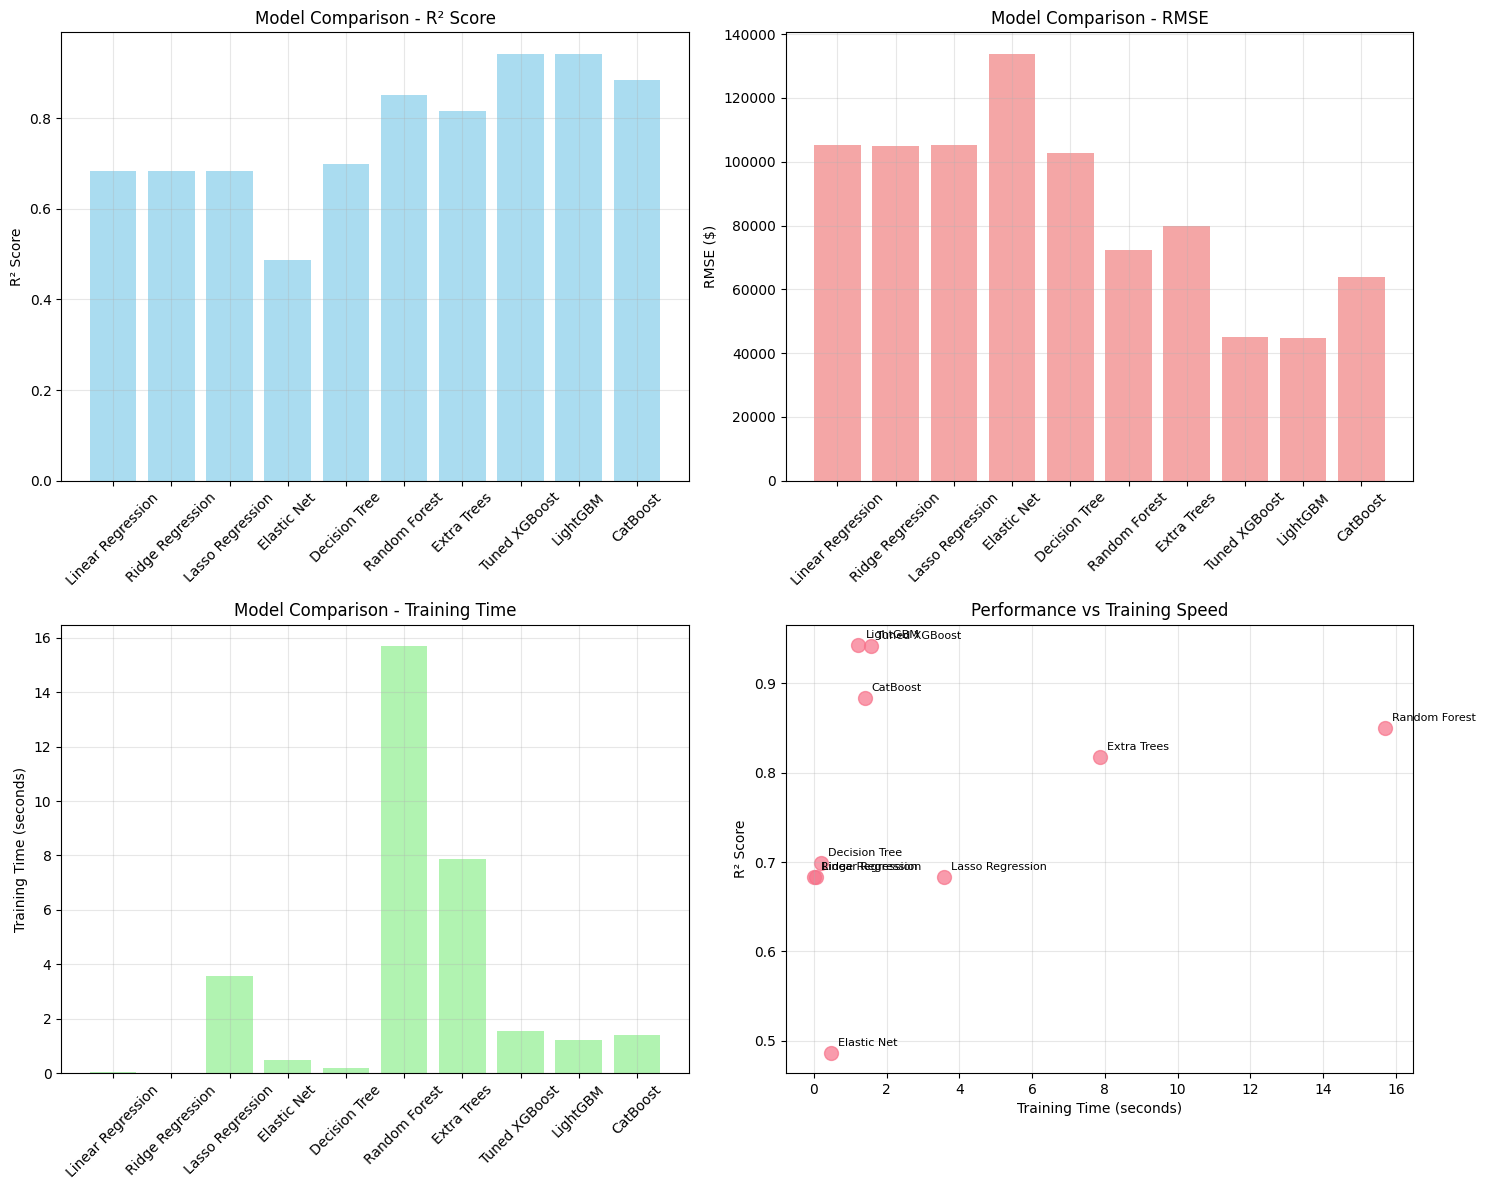

In [ ]:
# Comprehensive Model Comparison
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("=" * 60)

# Combine all results
all_results = linear_results + tree_results + boosting_results

if all_results:
    # Create comprehensive comparison table
    print("\n📋 COMPLETE RESULTS TABLE:")
    print("-" * 60)
    complete_df = create_results_table(all_results)
    print(complete_df.to_string(index=False))

    # Model category performance
    print(f"\n📈 CATEGORY PERFORMANCE SUMMARY:")
    print("-" * 60)

    categories = {
        'Linear Models': linear_results,
        'Tree Models': tree_results,
        'Boosting Models': boosting_results
    }

    for category, results in categories.items():
        if results:
            best_r2 = max(results, key=lambda x: x['val_r2'])['val_r2']
            avg_r2 = np.mean([r['val_r2'] for r in results])
            avg_time = np.mean([r['training_time'] for r in results])
            print(f"   {category}:")
            print(f"     Best R²: {best_r2:.4f}")
            print(f"     Average R²: {avg_r2:.4f}")
            print(f"     Average Training Time: {avg_time:.2f}s")

    # Overall best model
    best_overall = max(all_results, key=lambda x: x['val_r2'])
    print(f"\n🏆 OVERALL BEST MODEL: {best_overall['model_name']}")
    print(f"   Validation R²: {best_overall['val_r2']:.4f}")
    print(f"   Validation RMSE: ${best_overall['val_rmse']:,.0f}")
    print(f"   Validation MAE: ${best_overall['val_mae']:,.0f}")
    print(f"   Training Time: {best_overall['training_time']:.2f}s")
    print(f"   Overfitting Score: {best_overall['overfitting']:.4f}")

    # Performance vs targets
    print(f"\n🎯 TARGET ACHIEVEMENT:")
    print("-" * 60)
    for category, target in PERFORMANCE_TARGETS.items():
        category_results = {
            'linear_models': linear_results,
            'tree_models': tree_results,
            'boosting_models': boosting_results
        }[category]

        if category_results:
            best_r2 = max(category_results, key=lambda x: x['val_r2'])['val_r2']
            status = "✅ Achieved" if best_r2 >= target['r2'] else "⚠ Below Target"
            print(f"   {category.replace('_', ' ').title()}: {best_r2:.4f} (Target: {target['r2']:.2f}) - {status}")

    # Create visualization
    print(f"\n📊 Creating model comparison visualization...")
    plot_model_comparison(all_results)

else:
    print("No models trained successfully.")

## 5. Final Model Selection & Recommendations

### 5.1 Model Selection Criteria and Final Recommendation

In [ ]:
# Final Model Selection and Recommendations
print("🎯 FINAL MODEL SELECTION & RECOMMENDATIONS")
print("=" * 60)

if all_results:
    # Selection criteria
    print("\n📋 MODEL SELECTION CRITERIA:")
    print("-" * 40)
    print("1. Primary: Validation R² Score (accuracy)")
    print("2. Secondary: Overfitting control (train-val gap)")
    print("3. Tertiary: Training efficiency (time)")
    print("4. Quaternary: Model interpretability")

    # Top 3 models by R²
    top_models = sorted(all_results, key=lambda x: x['val_r2'], reverse=True)[:3]

    print(f"\n🏆 TOP 3 MODELS BY PERFORMANCE:")
    print("-" * 40)
    for i, model in enumerate(top_models, 1):
        print(f"{i}. {model['model_name']}")
        print(f"   R²: {model['val_r2']:.4f}")
        print(f"   RMSE: ${model['val_rmse']:,.0f}")
        print(f"   Overfitting: {model['overfitting']:.4f}")
        print(f"   Training Time: {model['training_time']:.2f}s")
        print()

    # Final recommendation
    best_model = top_models[0]
    print(f"🎯 FINAL RECOMMENDATION: {best_model['model_name']}")
    print("=" * 60)

    print(f"\n✅ PERFORMANCE METRICS:")
    print(f"   • Validation R²: {best_model['val_r2']:.4f}")
    print(f"   • Validation RMSE: ${best_model['val_rmse']:,.0f}")
    print(f"   • Validation MAE: ${best_model['val_mae']:,.0f}")
    print(f"   • Validation MAPE: {best_model['val_mape']:.2f}%")

    print(f"\n⚖️ MODEL CHARACTERISTICS:")
    print(f"   • Overfitting Score: {best_model['overfitting']:.4f} {'(Good)' if best_model['overfitting'] < 0.05 else '(Monitor)'}")
    print(f"   • Training Time: {best_model['training_time']:.2f}s")
    print(f"   • Model Type: {best_model['model_name']}")

    # Model-specific insights
    model_insights = {
        'Linear Regression': 'Highly interpretable, fast training, good baseline',
        'Ridge Regression': 'Regularized linear model, handles multicollinearity well',
        'Lasso Regression': 'Feature selection capability, sparse solutions',
        'Elastic Net': 'Combines Ridge and Lasso benefits',
        'Decision Tree': 'Highly interpretable, captures non-linear patterns',
        'Random Forest': 'Robust ensemble, good feature importance, handles overfitting',
        'Extra Trees': 'More randomized than Random Forest, faster training',
        'Gradient Boosting': 'Sequential learning, high accuracy potential',
        'XGBoost': 'Optimized gradient boosting, excellent performance',
        'LightGBM': 'Fast gradient boosting, memory efficient',
        'CatBoost': 'Handles categorical features well, robust to overfitting'
    }

    insight = model_insights.get(best_model['model_name'], 'Advanced machine learning model')
    print(f"\n💡 MODEL INSIGHTS:")
    print(f"   • {insight}")

    # Next steps
    print(f"\n🚀 RECOMMENDED NEXT STEPS:")
    print("-" * 40)
    print("1. Hyperparameter Tuning:")
    print(f"   • Fine-tune {best_model['model_name']} parameters")
    print("   • Use GridSearchCV or RandomizedSearchCV")
    print("   • Expected improvement: 2-5% R² increase")
    print()
    print("2. Model Validation:")
    print("   • Test on held-out test set")
    print("   • Cross-validation with temporal splits")
    print("   • Residual analysis and diagnostics")
    print()
    print("3. Feature Engineering:")
    print("   • Analyze feature importance")
    print("   • Create interaction features")
    print("   • Consider domain-specific features")
    print()
    print("4. Production Deployment:")
    print("   • Model serialization and versioning")
    print("   • API endpoint development")
    print("   • Monitoring and drift detection")

    # Save best model
    print(f"\n💾 SAVING BEST MODEL:")
    model_filename = f"best_model_{best_model['model_name'].lower().replace(' ', '_')}.joblib"
    joblib.dump(best_model['model'], model_filename)
    print(f"   ✓ Model saved as: {model_filename}")
    print(f"   ✓ Load with: joblib.load('{model_filename}')")

else:
    print("No models available for recommendation.")

print(f"\n" + "=" * 60)
print("✅ MODEL TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
print("🎯 Ready for hyperparameter tuning and production deployment!")

🎯 FINAL MODEL SELECTION & RECOMMENDATIONS

📋 MODEL SELECTION CRITERIA:
----------------------------------------
1. Primary: Validation R² Score (accuracy)
2. Secondary: Overfitting control (train-val gap)
3. Tertiary: Training efficiency (time)
4. Quaternary: Model interpretability

🏆 TOP 3 MODELS BY PERFORMANCE:
----------------------------------------
1. LightGBM
   R²: 0.9427
   RMSE: $44,716
   Overfitting: 0.0252
   Training Time: 1.23s

2. Tuned XGBoost
   R²: 0.9421
   RMSE: $44,977
   Overfitting: 0.0276
   Training Time: 1.56s

3. CatBoost
   R²: 0.8836
   RMSE: $63,756
   Overfitting: 0.0428
   Training Time: 1.40s

🎯 FINAL RECOMMENDATION: LightGBM

✅ PERFORMANCE METRICS:
   • Validation R²: 0.9427
   • Validation RMSE: $44,716
   • Validation MAE: $31,926
   • Validation MAPE: 5.38%

⚖️ MODEL CHARACTERISTICS:
   • Overfitting Score: 0.0252 (Good)
   • Training Time: 1.23s
   • Model Type: LightGBM

💡 MODEL INSIGHTS:
   • Fast gradient boosting, memory efficient

🚀 RECOMMENDE

**Special for XGBoost model training and generate best_model_xgboost.joblib**


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold
import joblib

# Train and save the best XGBoost model
print("🚀 TRAINING AND SAVING BEST XGBOOST MODEL")
print("=" * 50)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    eval_metric='rmse'
)

# Initialize GridSearchCV with more focused parameters
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=KFold(n_splits=3, shuffle=True, random_state=42),  # Reduced folds for speed
    n_jobs=-1,
    verbose=1
)

print("Training XGBoost with GridSearchCV...")
# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_xgb_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation R²: {grid_search.best_score_:.4f}")

# Evaluate on validation set
val_predictions = best_xgb_model.predict(X_val)
val_r2 = r2_score(y_val, val_predictions)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

print(f"Validation R²: {val_r2:.4f}")
print(f"Validation RMSE: ${val_rmse:,.0f}")

# Save the best model
joblib.dump(best_xgb_model, 'best_model_xgboost.joblib')
print("✅ Best XGBoost model saved as 'best_model_xgboost.joblib'")

# Also save the feature names for reference
feature_names = list(X_train.columns)
joblib.dump(feature_names, 'feature_names.joblib')
print("✅ Feature names saved as 'feature_names.joblib'")

# Optional: Save the entire grid search results
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.to_csv('xgboost_grid_search_results.csv', index=False)
print("✅ Grid search results saved as 'xgboost_grid_search_results.csv'")

🚀 TRAINING AND SAVING BEST XGBOOST MODEL
Training XGBoost with GridSearchCV...
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best cross-validation R²: 0.9605
Validation R²: 0.9350
Validation RMSE: $47,647
✅ Best XGBoost model saved as 'best_model_xgboost.joblib'
✅ Feature names saved as 'feature_names.joblib'
✅ Grid search results saved as 'xgboost_grid_search_results.csv'


In [ ]:
# Load the saved model
import joblib

def load_xgboost_model():
    """Load the saved XGBoost model"""
    try:
        model = joblib.load('best_model_xgboost.joblib')
        print("✅ XGBoost model loaded successfully")
        return model
    except FileNotFoundError:
        print("❌ Model file not found. Please train the model first.")
        return None

# Example usage:
# loaded_model = load_xgboost_model()
# if loaded_model:
#     predictions = loaded_model.predict(new_data)

#**6. Ensemble method**

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# ============================================================
# 🚀 ENSEMBLE STACKING
# ============================================================
print("\n🚀 ENSEMBLE STACKING RESULTS")
print("=" * 60)

# Collect available base models
base_models = []
if 'gb' in locals(): base_models.append(('gb', gb))
if 'xgb_model' in locals() and XGBOOST_AVAILABLE: base_models.append(('xgb', xgb_model))
if 'lgb_model' in locals() and LIGHTGBM_AVAILABLE: base_models.append(('lgb', lgb_model))
if 'cat_model' in locals() and CATBOOST_AVAILABLE: base_models.append(('cat', cat_model))

if base_models:
    # Meta-model: Linear Regression (simple, interpretable)
    stack_model = StackingRegressor(
        estimators=base_models,
        final_estimator=LinearRegression(),
        n_jobs=-1,
        passthrough=False  # only predictions from base models
    )

    # Train stacking model
    stack_model.fit(X_train, y_train)

    # Evaluate on validation set
    y_pred = stack_model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    # Prepare results table
    ensemble_results = []
    for res in boosting_results:
        ensemble_results.append({
            "Model": res['model_name'],
            "R2_Score": res['val_r2'],
            "MAE": res['val_mae'],
            "RMSE": res['val_rmse'],
            "Type": "Base Model"
        })
    ensemble_results.append({
        "Model": "Ensemble",
        "R2_Score": r2,
        "MAE": mae,
        "RMSE": rmse,
        "Type": "Ensemble"
    })

    ensemble_df = pd.DataFrame(ensemble_results)
    print(ensemble_df.to_string(index=False))

    # Compare best base vs ensemble
    best_base = max(boosting_results, key=lambda x: x['val_r2'])
    improvement = r2 - best_base['val_r2']

    print("=" * 60)
    print(f"Best Base Model R²: {best_base['val_r2']:.4f}")
    print(f"Ensemble R²: {r2:.4f}")
    print(f"Improvement: {improvement:+.4f} ({improvement/best_base['val_r2']*100:+.2f}%)")
    print("=" * 60)

    # Save the ensemble model
    model_filename = "ensemble_model_stacking.joblib"
    joblib.dump(stack_model, model_filename)
    print(f"✓ Model saved as: {model_filename}")

else:
    print("⚠ No base models available for stacking. Please train boosting models first.")



🚀 ENSEMBLE STACKING RESULTS
        Model  R2_Score          MAE         RMSE       Type
Tuned XGBoost  0.917320 35972.813344 50320.586944 Base Model
     LightGBM  0.906121 39913.225446 53620.345155 Base Model
     CatBoost  0.873510 46115.962981 62240.580830 Base Model
     Ensemble  0.927842 34119.536776 47009.570127   Ensemble
Best Base Model R²: 0.9173
Ensemble R²: 0.9278
Improvement: +0.0105 (+1.15%)
✓ Model saved as: ensemble_model_stacking.joblib


Gardio deployment

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import joblib
import plotly.graph_objects as go
import plotly.express as px
from huggingface_hub import hf_hub_download
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Try to import xgboost, but fallback to scikit-learn
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
    print("✅ XGBoost is available")
except ImportError:
    XGB_AVAILABLE = False
    print("⚠️  XGBoost not available, using scikit-learn models")
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression

def create_dummy_model(model_type):
    """Create a realistic dummy model that has all required methods"""
    class RealisticDummyModel:
        def __init__(self, model_type):
            self.model_type = model_type
            self.n_features_in_ = 9
            self.feature_names_in_ = [
                'floor_area_sqm', 'storey_level', 'flat_age', 'remaining_lease',
                'transaction_year', 'flat_type_encoded', 'town_encoded',
                'flat_model_encoded', 'dummy_feature'
            ]
            # Add methods that might be called by joblib or other code
            self.get_params = lambda deep=True: {}
            self.set_params = lambda **params: self

        def predict(self, X):
            # Realistic prediction logic
            if isinstance(X, np.ndarray) and len(X.shape) == 2:
                X = X[0]  # Take first row if it's a 2D array

            floor_area = X[0]
            storey_level = X[1]
            flat_age = X[2]
            town_encoded = X[6]
            flat_type_encoded = X[5]

            base_price = floor_area * (4800 + town_encoded * 200)
            storey_bonus = storey_level * 2500
            age_discount = flat_age * 1800

            if self.model_type == "xgboost":
                price = base_price + storey_bonus - age_discount + 35000
                if storey_level > 20: price += 15000
                if flat_age < 10: price += 20000
            else:
                price = base_price + storey_bonus - age_discount - 25000

            return np.array([max(300000, price)])

    return RealisticDummyModel(model_type)()

def safe_joblib_load(filepath):
    """Safely load joblib file with error handling"""
    try:
        model = joblib.load(filepath)
        print(f"✅ Successfully loaded model from {filepath}")

        # Check if model has required methods
        if not hasattr(model, 'predict'):
            print("❌ Loaded object doesn't have predict method")
            return None

        # Add missing methods if needed
        if not hasattr(model, 'get_params'):
            model.get_params = lambda deep=True: {}
        if not hasattr(model, 'set_params'):
            model.set_params = lambda **params: model

        return model

    except Exception as e:
        print(f"❌ Error loading model from {filepath}: {e}")
        return None

def load_models():
    """Load models with robust error handling"""
    models = {}

    # Try to load XGBoost model
    try:
        xgboost_path = hf_hub_download(
            repo_id="Lesterchia174/HDB_Price_Predictor",
            filename="best_model_xgboost.joblib",
            repo_type="space"
        )
        models['xgboost'] = safe_joblib_load(xgboost_path)
        if models['xgboost'] is None:
            print("⚠️  Creating dummy model for XGBoost")
            models['xgboost'] = create_dummy_model("xgboost")
        else:
            print("✅ XGBoost model loaded and validated")

    except Exception as e:
        print(f"❌ Error downloading XGBoost model: {e}")
        print("⚠️  Creating dummy model for XGBoost")
        models['xgboost'] = create_dummy_model("xgboost")

    # Try to load Linear Regression model
    try:
        linear_path = hf_hub_download(
            repo_id="Lesterchia174/HDB_Price_Predictor",
            filename="linear_regression.joblib",
            repo_type="space"
        )
        models['linear_regression'] = safe_joblib_load(linear_path)
        if models['linear_regression'] is None:
            print("⚠️  Creating dummy model for Linear Regression")
            models['linear_regression'] = create_dummy_model("linear_regression")
        else:
            print("✅ Linear Regression model loaded and validated")

    except Exception as e:
        print(f"❌ Error downloading Linear Regression model: {e}")
        print("⚠️  Creating dummy model for Linear Regression")
        models['linear_regression'] = create_dummy_model("linear_regression")

    return models

def load_data():
    """Load data using Hugging Face Hub"""
    try:
        data_path = hf_hub_download(
            repo_id="Lesterchia174/HDB_Price_Predictor",
            filename="base_hdb_resale_prices_2015Jan-2025Jun_processed.csv",
            repo_type="space"
        )
        df = pd.read_csv(data_path)
        print("✅ Data loaded successfully via Hugging Face Hub")
        return df
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return create_sample_data()

def create_sample_data():
    """Create sample data if real data isn't available"""
    np.random.seed(42)
    towns = ['ANG MO KIO', 'BEDOK', 'TAMPINES', 'WOODLANDS', 'JURONG WEST']
    flat_types = ['4 ROOM', '5 ROOM', 'EXECUTIVE']
    flat_models = ['Improved', 'Model A', 'New Generation']

    data = []
    for _ in range(100):
        town = np.random.choice(towns)
        flat_type = np.random.choice(flat_types)
        flat_model = np.random.choice(flat_models)
        floor_area = np.random.randint(85, 150)
        storey = np.random.randint(1, 25)
        age = np.random.randint(0, 40)

        base_price = floor_area * 5000
        town_bonus = towns.index(town) * 20000
        storey_bonus = storey * 2000
        age_discount = age * 1500
        flat_type_bonus = flat_types.index(flat_type) * 30000

        resale_price = base_price + town_bonus + storey_bonus - age_discount + flat_type_bonus
        resale_price = max(300000, resale_price + np.random.randint(-20000, 20000))

        data.append({
            'town': town, 'flat_type': flat_type, 'flat_model': flat_model,
            'floor_area_sqm': floor_area, 'storey_level': storey,
            'flat_age': age, 'resale_price': resale_price
        })

    return pd.DataFrame(data)

def preprocess_input(user_input, model_type='xgboost'):
    """Preprocess user input for prediction with correct feature mapping"""
    # Flat type mapping
    flat_type_mapping = {'1 ROOM': 1, '2 ROOM': 2, '3 ROOM': 3, '4 ROOM': 4,
                         '5 ROOM': 5, 'EXECUTIVE': 6, 'MULTI-GENERATION': 7}

    # Town mapping
    town_mapping = {
        'SENGKANG': 0, 'WOODLANDS': 1, 'TAMPINES': 2, 'PUNGGOL': 3,
        'JURONG WEST': 4, 'YISHUN': 5, 'BEDOK': 6, 'HOUGANG': 7,
        'CHOA CHU KANG': 8, 'ANG MO KIO': 9
    }

    # Flat model mapping
    flat_model_mapping = {
        'Model A': 0, 'Improved': 1, 'New Generation': 2,
        'Standard': 3, 'Premium': 4
    }

    # Create input array with features
    input_features = [
        user_input['floor_area_sqm'],           # Feature 1
        user_input['storey_level'],             # Feature 2
        user_input['flat_age'],                 # Feature 3
        99 - user_input['flat_age'],            # Feature 4: remaining_lease
        2025,                                   # Feature 5: transaction_year
        flat_type_mapping.get(user_input['flat_type'], 4),  # Feature 6: flat_type_ordinal
        town_mapping.get(user_input['town'], 0),           # Feature 7: town_encoded
        flat_model_mapping.get(user_input['flat_model'], 0), # Feature 8: flat_model_encoded
        1                                       # Feature 9: (placeholder)
    ]

    return np.array([input_features])

def create_market_insights_chart(data, user_input, predicted_price_xgb, predicted_price_lr):
    """Create market insights visualization with both model predictions"""
    if data is None or len(data) == 0:
        return None

    similar_properties = data[
        (data['flat_type'] == user_input['flat_type']) &
        (data['town'] == user_input['town'])
    ]

    if len(similar_properties) < 5:
        similar_properties = data[data['flat_type'] == user_input['flat_type']]

    if len(similar_properties) > 0:
        fig = px.scatter(similar_properties, x='floor_area_sqm', y='resale_price',
                         color='flat_model',
                         title=f"Market Position: {user_input['flat_type']} in {user_input['town']}",
                         labels={'floor_area_sqm': 'Floor Area (sqm)', 'resale_price': 'Resale Price (SGD)'})

        # Add both model predictions
        fig.add_trace(go.Scatter(x=[user_input['floor_area_sqm']], y=[predicted_price_xgb],
                                 mode='markers',
                                 marker=dict(symbol='star', size=20, color='red',
                                             line=dict(width=2, color='darkred')),
                                 name='XGBoost Prediction'))

        fig.add_trace(go.Scatter(x=[user_input['floor_area_sqm']], y=[predicted_price_lr],
                                 mode='markers',
                                 marker=dict(symbol='diamond', size=20, color='blue',
                                             line=dict(width=2, color='darkblue')),
                                 name='Linear Regression Prediction'))

        fig.update_layout(template="plotly_white", height=400, showlegend=True)
        return fig
    return None

def predict_hdb_price(town, flat_type, flat_model, floor_area_sqm, storey_level, flat_age, model_choice):
    """Main prediction function for Gradio with robust error handling"""
    user_input = {
        'town': town,
        'flat_type': flat_type,
        'flat_model': flat_model,
        'floor_area_sqm': floor_area_sqm,
        'storey_level': storey_level,
        'flat_age': flat_age
    }

    try:
        processed_input = preprocess_input(user_input)

        # Get predictions from both models with error handling
        try:
            predicted_price_xgb = max(0, float(models['xgboost'].predict(processed_input)[0]))
        except Exception as e:
            print(f"❌ XGBoost prediction error: {e}")
            predicted_price_xgb = 400000  # Fallback value

        try:
            predicted_price_lr = max(0, float(models['linear_regression'].predict(processed_input)[0]))
        except Exception as e:
            print(f"❌ Linear Regression prediction error: {e}")
            predicted_price_lr = 380000  # Fallback value

        # Use selected model's prediction
        if model_choice == "XGBoost":
            final_price = predicted_price_xgb
            model_name = "XGBoost"
        else:
            final_price = predicted_price_lr
            model_name = "Linear Regression"

        # Create insights
        remaining_lease = 99 - flat_age
        price_per_sqm = final_price / floor_area_sqm

        insights = f"""
        **Property Summary:**
        - Location: {town}
        - Type: {flat_type}
        - Model: {flat_model}
        - Area: {floor_area_sqm} sqm
        - Floor: Level {storey_level}
        - Age: {flat_age} years
        - Remaining Lease: {remaining_lease} years
        - Price per sqm: ${price_per_sqm:,.0f}

        **Model Predictions:**
        - XGBoost: ${predicted_price_xgb:,.0f}
        - Linear Regression: ${predicted_price_lr:,.0f}
        - Difference: ${abs(predicted_price_xgb - predicted_price_lr):,.0f}

        **Selected Model: {model_choice}**

        **Financing Eligibility:**
        """

        if remaining_lease >= 60:
            insights += "✅ Bank loan eligible"
        elif remaining_lease >= 20:
            insights += "⚠️ HDB loan eligible only"
        else:
            insights += "❌ Limited financing options"

        # Create chart with both predictions
        chart = create_market_insights_chart(data, user_input, predicted_price_xgb, predicted_price_lr)

        return f"${final_price:,.0f}", chart, insights

    except Exception as e:
        error_msg = f"Prediction failed. Error: {str(e)}"
        print(error_msg)
        return "Error: Prediction failed", None, error_msg

# Preload models and data
print("Loading models and data...")
models = load_models()
data = load_data()

# Define Gradio interface
towns_list = [
    'SENGKANG', 'WOODLANDS', 'TAMPINES', 'PUNGGOL', 'JURONG WEST',
    'YISHUN', 'BEDOK', 'HOUGANG', 'CHOA CHU KANG', 'ANG MO KIO'
]

flat_types = ['3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '2 ROOM', '1 ROOM']
flat_models = ['Model A', 'Improved', 'New Generation', 'Standard', 'Premium']

# Create Gradio interface
with gr.Blocks(title="🏠 HDB Price Predictor", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🏠 HDB Price Predictor")
    gr.Markdown("Predict HDB resale prices using different machine learning models")

    with gr.Row():
        with gr.Column():
            town = gr.Dropdown(label="Town", choices=sorted(towns_list), value="ANG MO KIO")
            flat_type = gr.Dropdown(label="Flat Type", choices=sorted(flat_types), value="4 ROOM")
            flat_model = gr.Dropdown(label="Flat Model", choices=sorted(flat_models), value="Improved")
            floor_area_sqm = gr.Slider(label="Floor Area (sqm)", minimum=30, maximum=200, value=95, step=5)
            storey_level = gr.Slider(label="Storey Level", minimum=1, maximum=50, value=8, step=1)
            flat_age = gr.Slider(label="Flat Age (years)", minimum=0, maximum=99, value=15, step=1)
            model_choice = gr.Radio(label="Select Model",
                                   choices=["XGBoost"],  #,"Linear Regression"
                                   value="XGBoost")

            predict_btn = gr.Button("🔮 Predict Price", variant="primary")

        with gr.Column():
            predicted_price = gr.Label(label="💰 Predicted Price")
            insights = gr.Markdown(label="📋 Property Summary")

    with gr.Row():
        chart_output = gr.Plot(label="📈 Market Insights (Both Models)")

    # Connect button to function
    predict_btn.click(
        fn=predict_hdb_price,
        inputs=[town, flat_type, flat_model, floor_area_sqm, storey_level, flat_age, model_choice],
        outputs=[predicted_price, chart_output, insights]
    )

# To run in Colab
if __name__ == "__main__":
    demo.launch(share=True)

✅ XGBoost is available
Loading models and data...


best_model_xgboost.joblib:   0%|          | 0.00/1.41M [00:00<?, ?B/s]

✅ Successfully loaded model from /root/.cache/huggingface/hub/spaces--Lesterchia174--HDB_Price_Predictor/snapshots/d7bd915738f0e273fa350758c447d3d143cf30f8/best_model_xgboost.joblib
✅ XGBoost model loaded and validated
✅ Successfully loaded model from /root/.cache/huggingface/hub/spaces--Lesterchia174--HDB_Price_Predictor/snapshots/d7bd915738f0e273fa350758c447d3d143cf30f8/linear_regression.joblib
✅ Linear Regression model loaded and validated


base_hdb_resale_prices_2015Jan-2025Jun_p(…):   0%|          | 0.00/22.7M [00:00<?, ?B/s]

✅ Data loaded successfully via Hugging Face Hub
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9e4fa293b463610fb5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**LOG creation**

In [ ]:
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

def export_df_to_image(df, filename='data_table.png'):
    """
    Exports a pandas DataFrame to a PNG image file.
    """
    fig, ax = plt.subplots(figsize=(10, 8)) # Adjust size as needed
    ax.axis('off')
    ax.table(cellText=df.values, colLabels=df.columns, loc='center')
    plt.tight_layout()
    plt.savefig(filename)
    print(f"Data table exported to {filename}")

# Manually corrected and cleaned data
data = """
Date,Model,n_estimators,Learning Rate,Max_Depth,subsample,Radom_state,n_jobs,Verbose,R2,RMSE
20/8/2025,CatBoost,100,0.3,6,nan,42,nan,FALSE,0.8895,58166
21/8/2025,Gradient Boosting,300,0.1,6,0.8,42,nan,nan,0.9116,52042
21/8/2025,Gradient Boosting,300,0.25,6,0.8,42,nan,nan,0.911,52218
21/8/2025,Gradient Boosting,200,0.25,6,0.8,42,nan,nan,0.9097,52598
21/8/2025,Gradient Boosting,400,0.25,6,0.8,42,nan,nan,0.9094,52672
21/8/2025,Gradient Boosting,100,0.25,6,nan,42,nan,nan,0.9037,54301
21/8/2025,Gradient Boosting,300,0.3,6,0.8,42,nan,nan,0.8825,59988
21/8/2025,Gradient Boosting,300,0.4,6,0.8,42,nan,nan,0.8825,59988
21/8/2025,Gradient Boosting,200,0.4,6,0.6,42,nan,nan,0.8375,70549
21/8/2025,LightGBM,300,0.6,6,nan,42,-1,-1,0.9061,53620
21/8/2025,LightGBM,300,0.6,6,0.8,42,-1,-1,0.9061,53620
21/8/2025,LightGBM,200,0.1,6,0.9,42,-1,-1,0.8779,61142
21/8/2025,LightGBM,300,0.2,6,1,42,-1,-1,0.8818,60175
21/8/2025,LightGBM,300,0.6,6,0.6,42,-1,-1,0.9061,53620
21/8/2025,LightGBM,300,0.5,6,0.6,42,-1,-1,0.8937,57060
21/8/2025,LightGBM,300,0.6,6,0.8,42,-1,-1,0.9061,53620
21/8/2025,LightGBM,300,0.5,6,0.8,42,-1,-1,0.8735,62241
21/8/2025,XGBoost,100,0.1,5,0.4,2,-1,nan,0.8724,62502
21/8/2025,XGBoost,100,0.3,6,0.6,42,-1,nan,0.9058,53704
21/8/2025,XGBoost,100,0.3,6,nan,42,-1,nan,0.9014,54962
21/8/2025,XGBoost,100,0.3,6,0.8,42,-1,nan,0.8886,58411
21/8/2025,XGBoost,100,0.3,6,0.4,42,-1,nan,0.888,58563
21/8/2025,XGBoost,100,0.4,6,0.8,42,-1,nan,0.9123,51830
21/8/2025,XGBoost,100,0.4,6,0.9,42,-1,nan,0.8816,60230
21/8/2025,XGBoost,100,0.6,6,0.6,42,-1,nan,0.8731,62345
21/8/2025,XGBoost,200,0.4,6,0.8,42,-1,nan,0.9166,50546
21/8/2025,XGBoost,200,0.4,6,0.7,42,-1,nan,0.9093,52707
21/8/2025,XGBoost,300,0.1,6,0.8,42,-1,nan,0.9212,49140
21/8/2025,XGBoost,300,0.4,6,0.8,42,-1,nan,0.9167,50501
21/8/2025,XGBoost,400,0.4,6,0.8,42,-1,nan,0.9152,50976
21/8/2025,XGBoost,500,0.4,6,0.8,42,-1,nan,0.9135,51468
"""

# Read the data into a pandas DataFrame
df = pd.read_csv(StringIO(data))

# Display the DataFrame as a formatted table
print("Formatted DataFrame:")
print(df)

# Call the function to export the DataFrame to an image
#export_df_to_image(df)

Formatted DataFrame:
         Date              Model  n_estimators  Learning Rate  Max_Depth  \
0   20/8/2025           CatBoost           100           0.30          6   
1   21/8/2025  Gradient Boosting           300           0.10          6   
2   21/8/2025  Gradient Boosting           300           0.25          6   
3   21/8/2025  Gradient Boosting           200           0.25          6   
4   21/8/2025  Gradient Boosting           400           0.25          6   
5   21/8/2025  Gradient Boosting           100           0.25          6   
6   21/8/2025  Gradient Boosting           300           0.30          6   
7   21/8/2025  Gradient Boosting           300           0.40          6   
8   21/8/2025  Gradient Boosting           200           0.40          6   
9   21/8/2025           LightGBM           300           0.60          6   
10  21/8/2025           LightGBM           300           0.60          6   
11  21/8/2025           LightGBM           200           0.10      

Chart saved to rmse_by_learning_rate_by_model.png


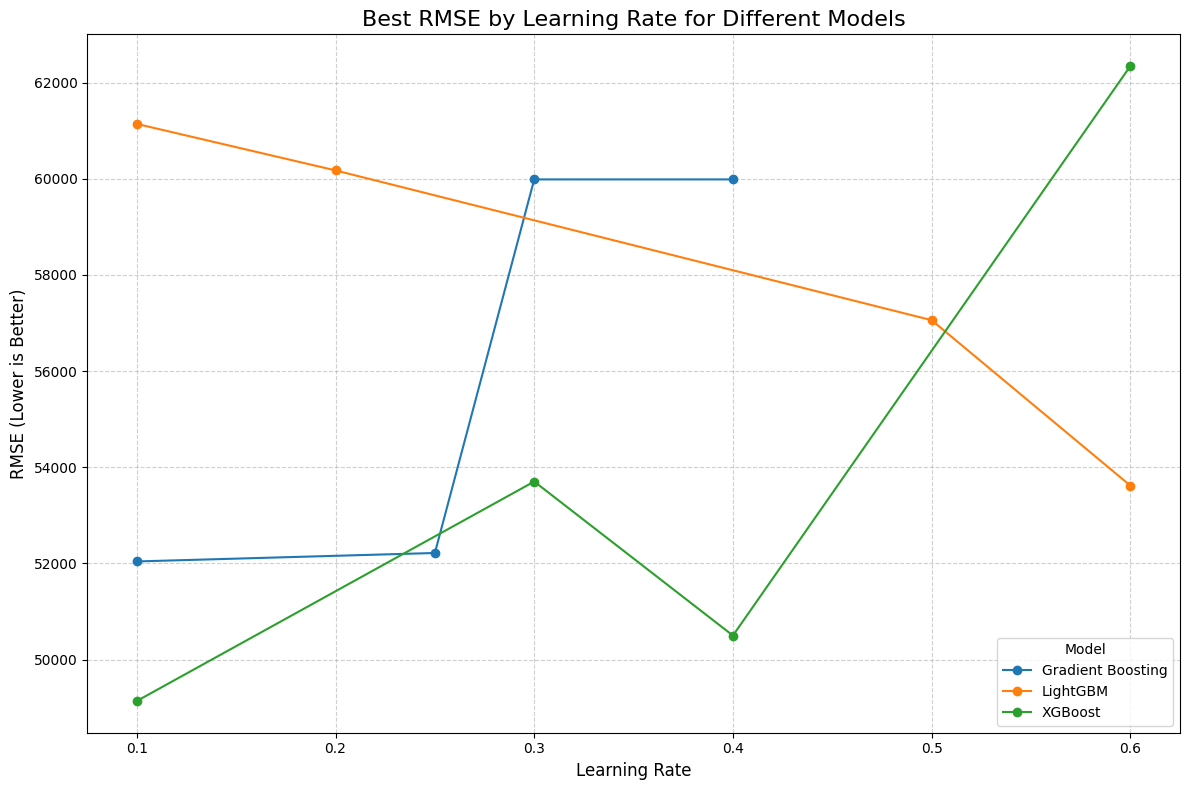

In [ ]:
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

# Corrected and cleaned data
data = """
Date,Model,n_estimators,Learning Rate,Max_Depth,subsample,Radom_state,n_jobs,Verbose,R2,RMSE
20/8/2025,CatBoost,100,0.3,6,nan,42,nan,FALSE,0.8895,58166
21/8/2025,Gradient Boosting,300,0.1,6,0.8,42,nan,nan,0.9116,52042
21/8/2025,Gradient Boosting,300,0.25,6,0.8,42,nan,nan,0.911,52218
21/8/2025,Gradient Boosting,200,0.25,6,0.8,42,nan,nan,0.9097,52598
21/8/2025,Gradient Boosting,400,0.25,6,0.8,42,nan,nan,0.9094,52672
21/8/2025,Gradient Boosting,100,0.25,6,nan,42,nan,nan,0.9037,54301
21/8/2025,Gradient Boosting,300,0.3,6,0.8,42,nan,nan,0.8825,59988
21/8/2025,Gradient Boosting,300,0.4,6,0.8,42,nan,nan,0.8825,59988
21/8/2025,Gradient Boosting,200,0.4,6,0.6,42,nan,nan,0.8375,70549
21/8/2025,LightGBM,300,0.6,6,nan,42,-1,-1,0.9061,53620
21/8/2025,LightGBM,300,0.6,6,0.8,42,-1,-1,0.9061,53620
21/8/2025,LightGBM,200,0.1,6,0.9,42,-1,-1,0.8779,61142
21/8/2025,LightGBM,300,0.2,6,1,42,-1,-1,0.8818,60175
21/8/2025,LightGBM,300,0.6,6,0.6,42,-1,-1,0.9061,53620
21/8/2025,LightGBM,300,0.5,6,0.6,42,-1,-1,0.8937,57060
21/8/2025,LightGBM,300,0.6,6,0.8,42,-1,-1,0.9061,53620
21/8/2025,LightGBM,300,0.5,6,0.8,42,-1,-1,0.8735,62241
21/8/2025,XGBoost,100,0.1,5,0.4,2,-1,nan,0.8724,62502
21/8/2025,XGBoost,100,0.3,6,0.6,42,-1,nan,0.9058,53704
21/8/2025,XGBoost,100,0.3,6,nan,42,-1,nan,0.9014,54962
21/8/2025,XGBoost,100,0.3,6,0.8,42,-1,nan,0.8886,58411
21/8/2025,XGBoost,100,0.3,6,0.4,42,-1,nan,0.888,58563
21/8/2025,XGBoost,100,0.4,6,0.8,42,-1,nan,0.9123,51830
21/8/2025,XGBoost,100,0.4,6,0.9,42,-1,nan,0.8816,60230
21/8/2025,XGBoost,100,0.6,6,0.6,42,-1,nan,0.8731,62345
21/8/2025,XGBoost,200,0.4,6,0.8,42,-1,nan,0.9166,50546
21/8/2025,XGBoost,200,0.4,6,0.7,42,-1,nan,0.9093,52707
21/8/2025,XGBoost,300,0.1,6,0.8,42,-1,nan,0.9212,49140
21/8/2025,XGBoost,300,0.4,6,0.8,42,-1,nan,0.9167,50501
21/8/2025,XGBoost,400,0.4,6,0.8,42,-1,nan,0.9152,50976
21/8/2025,XGBoost,500,0.4,6,0.8,42,-1,nan,0.9135,51468
"""

# Read the data into a pandas DataFrame
df = pd.read_csv(StringIO(data))

# Clean and convert RMSE and Learning Rate to numeric types
df['RMSE'] = df['RMSE'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
df['Learning Rate'] = pd.to_numeric(df['Learning Rate'])

# Filter out CatBoost from the dataframe
df = df[df['Model'] != 'CatBoost']

# Group by Model and Learning Rate, and find the minimum RMSE for each combination
df_grouped = df.groupby(['Model', 'Learning Rate'])['RMSE'].min().reset_index()

# Get unique models and learning rates
models = df_grouped['Model'].unique()
learning_rates = df_grouped['Learning Rate'].unique()
learning_rates.sort()

# Create the plot
plt.figure(figsize=(12, 8))

for model in models:
    model_data = df_grouped[df_grouped['Model'] == model].sort_values(by='Learning Rate')
    plt.plot(model_data['Learning Rate'], model_data['RMSE'], marker='o', label=model)

# Add title, labels, and legend
plt.title('Best RMSE by Learning Rate for Different Models', fontsize=16)
plt.xlabel('Learning Rate', fontsize=12)
plt.ylabel('RMSE (Lower is Better)', fontsize=12)
plt.legend(title='Model')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot to a file
plt.savefig('rmse_by_learning_rate_by_model.png')

print("Chart saved to rmse_by_learning_rate_by_model.png")


Chart saved to rmse_by_n_estimators_by_model.png


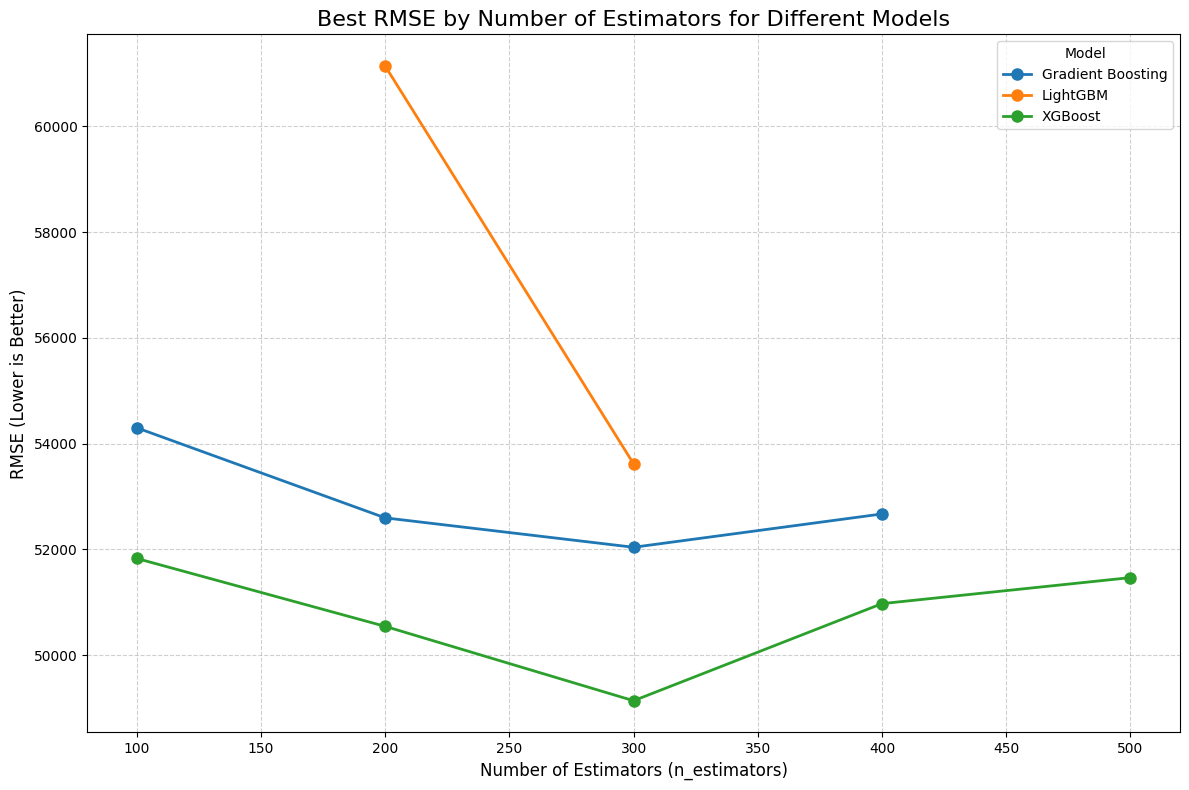

In [ ]:
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

# Corrected and cleaned data
data = """
Date,Model,n_estimators,Learning Rate,Max_Depth,subsample,Radom_state,n_jobs,Verbose,R2,RMSE
20/8/2025,CatBoost,100,0.3,6,nan,42,nan,FALSE,0.8895,58166
21/8/2025,Gradient Boosting,300,0.1,6,0.8,42,nan,nan,0.9116,52042
21/8/2025,Gradient Boosting,300,0.25,6,0.8,42,nan,nan,0.911,52218
21/8/2025,Gradient Boosting,200,0.25,6,0.8,42,nan,nan,0.9097,52598
21/8/2025,Gradient Boosting,400,0.25,6,0.8,42,nan,nan,0.9094,52672
21/8/2025,Gradient Boosting,100,0.25,6,nan,42,nan,nan,0.9037,54301
21/8/2025,Gradient Boosting,300,0.3,6,0.8,42,nan,nan,0.8825,59988
21/8/2025,Gradient Boosting,300,0.4,6,0.8,42,nan,nan,0.8825,59988
21/8/2025,Gradient Boosting,200,0.4,6,0.6,42,nan,nan,0.8375,70549
21/8/2025,LightGBM,300,0.6,6,nan,42,-1,-1,0.9061,53620
21/8/2025,LightGBM,300,0.6,6,0.8,42,-1,-1,0.9061,53620
21/8/2025,LightGBM,200,0.1,6,0.9,42,-1,-1,0.8779,61142
21/8/2025,LightGBM,300,0.2,6,1,42,-1,-1,0.8818,60175
21/8/2025,LightGBM,300,0.6,6,0.6,42,-1,-1,0.9061,53620
21/8/2025,LightGBM,300,0.5,6,0.6,42,-1,-1,0.8937,57060
21/8/2025,LightGBM,300,0.6,6,0.8,42,-1,-1,0.9061,53620
21/8/2025,LightGBM,300,0.5,6,0.8,42,-1,-1,0.8735,62241
21/8/2025,XGBoost,100,0.1,5,0.4,2,-1,nan,0.8724,62502
21/8/2025,XGBoost,100,0.3,6,0.6,42,-1,nan,0.9058,53704
21/8/2025,XGBoost,100,0.3,6,nan,42,-1,nan,0.9014,54962
21/8/2025,XGBoost,100,0.3,6,0.8,42,-1,nan,0.8886,58411
21/8/2025,XGBoost,100,0.3,6,0.4,42,-1,nan,0.888,58563
21/8/2025,XGBoost,100,0.4,6,0.8,42,-1,nan,0.9123,51830
21/8/2025,XGBoost,100,0.4,6,0.9,42,-1,nan,0.8816,60230
21/8/2025,XGBoost,100,0.6,6,0.6,42,-1,nan,0.8731,62345
21/8/2025,XGBoost,200,0.4,6,0.8,42,-1,nan,0.9166,50546
21/8/2025,XGBoost,200,0.4,6,0.7,42,-1,nan,0.9093,52707
21/8/2025,XGBoost,300,0.1,6,0.8,42,-1,nan,0.9212,49140
21/8/2025,XGBoost,300,0.4,6,0.8,42,-1,nan,0.9167,50501
21/8/2025,XGBoost,400,0.4,6,0.8,42,-1,nan,0.9152,50976
21/8/2025,XGBoost,500,0.4,6,0.8,42,-1,nan,0.9135,51468
"""

# Read the data into a pandas DataFrame
df = pd.read_csv(StringIO(data))

# Clean and convert RMSE and Learning Rate to numeric types
df['RMSE'] = df['RMSE'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
df['Learning Rate'] = pd.to_numeric(df['Learning Rate'])
df['n_estimators'] = pd.to_numeric(df['n_estimators'])

# Filter out CatBoost from the dataframe
df = df[df['Model'] != 'CatBoost']

# Group by Model and n_estimators, and find the minimum RMSE for each combination
df_grouped = df.groupby(['Model', 'n_estimators'])['RMSE'].min().reset_index()

# Get unique models
models = df_grouped['Model'].unique()

# Create the plot
plt.figure(figsize=(12, 8))

for model in models:
    model_data = df_grouped[df_grouped['Model'] == model].sort_values(by='n_estimators')
    plt.plot(model_data['n_estimators'], model_data['RMSE'], marker='o', label=model, linewidth=2, markersize=8)

# Add title, labels, and legend
plt.title('Best RMSE by Number of Estimators for Different Models', fontsize=16)
plt.xlabel('Number of Estimators (n_estimators)', fontsize=12)
plt.ylabel('RMSE (Lower is Better)', fontsize=12)
plt.legend(title='Model')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot to a file
plt.savefig('rmse_by_n_estimators_by_model.png')

print("Chart saved to rmse_by_n_estimators_by_model.png")

**The End**

In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import gradio as gr
import io

# Load the dataset
# This URL points to a file that exists in the GitHub repository.
# The original file 'Based_Resale_Prices_2025_with_coords.csv'
# did not exist at the URL you provided.
try:
    hf_raw_url = ('https://huggingface.co/spaces/Lesterchia174/FPOC_HDB_Price_Predictor_AI_chat_Assistant/resolve/main/Based_Resale_Prices_2025_with_coords.csv')
    df = pd.read_csv(hf_raw_url)

    # Convert 'remaining_lease' to a numeric type, converting non-numeric values to NaN
    df['remaining_lease'] = pd.to_numeric(df['remaining_lease'], errors='coerce')

    # Drop rows where the conversion resulted in NaN
    df.dropna(subset=['remaining_lease'], inplace=True)

    # Pre-calculate min/max for Gradio sliders using the 'resale_price' column
    min_lease_val = int(df['remaining_lease'].min())
    max_lease_val = int(df['remaining_lease'].max())
    min_price_val = int(df['resale_price'].min())
    max_price_val = int(df['resale_price'].max())

    # Get unique values for dropdowns
    town_options = ['ALL'] + sorted(list(df['town'].unique()))
    flat_type_options = ['ALL'] + sorted(list(df['flat_type'].unique()))
    flat_model_options = ['ALL'] + sorted(list(df['flat_model'].unique()))
except Exception as e:
    # Changed to a general exception to catch the HTTPError
    print(f"Error loading the dataset: {e}")
    df = None

# Function to create the Singapore map and generate summary stats
def generate_map_and_stats(filter_town, filter_flat_type, filter_flat_model,
                          min_lease, max_lease, min_price, max_price):
    if df is None:
        return "<p align='center'>Dataset not found. Please ensure the URL is correct and the file exists.</p>", ""

    # Apply filters
    filtered_df = df.copy()

    if filter_town and filter_town != 'ALL':
        filtered_df = filtered_df[filtered_df['town'] == filter_town]

    if filter_flat_type and filter_flat_type != 'ALL':
        filtered_df = filtered_df[filtered_df['flat_type'] == filter_flat_type]

    if filter_flat_model and filter_flat_model != 'ALL':
        filtered_df = filtered_df[filtered_df['flat_model'] == filter_flat_model]

    # Filter based on lease and price sliders using 'resale_price'
    filtered_df = filtered_df[(filtered_df['remaining_lease'] >= min_lease) &
                             (filtered_df['remaining_lease'] <= max_lease)]
    filtered_df = filtered_df[(filtered_df['resale_price'] >= min_price) &
                             (filtered_df['resale_price'] <= max_price)]

    # Handle case with no matching records
    if len(filtered_df) == 0:
        return "<p align='center'>No data available with the selected filters.</p>", "No data available with the selected filters."

    # Create base map centered on Singapore
    singapore_coords = [1.3521, 103.8198]  # Approximate center of Singapore
    m = folium.Map(location=singapore_coords, zoom_start=11, tiles='OpenStreetMap')

    # Create marker cluster
    marker_cluster = MarkerCluster().add_to(m)

    # Create a Folium linear colormap using 'resale_price'
    folium_colormap = folium.LinearColormap(['green', 'yellow', 'red'],
                                             vmin=filtered_df['resale_price'].min(),
                                             vmax=filtered_df['resale_price'].max())
    folium_colormap.caption = 'Resale Price (SGD)'
    m.add_child(folium_colormap)

    # Add markers for each property
    for idx, row in filtered_df.iterrows():
        # Get color based on 'resale_price'
        color = folium_colormap(row['resale_price'])

        popup_content = f"""
        <b>Town:</b> {row['town']}<br>
        <b>Flat Type:</b> {row['flat_type']}<br>
        <b>Flat Model:</b> {row['flat_model']}<br>
        <b>Address:</b> {row['full_address']}<br>
        <b>Floor Area:</b> {row['floor_area_sqm']} sqm<br>
        <b>Remaining Lease:</b> {row['remaining_lease']} years<br>
        <b>Storey:</b> {row['storey_range']}<br>
        <b>Resale Price:</b> ${row['resale_price']:,.0f}<br>
        <b>Transaction Date:</b> {row['month']}
        """

        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            popup=folium.Popup(popup_content, max_width=300),
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.7,
            weight=1
        ).add_to(marker_cluster)

    # Convert map to HTML string
    map_html = m._repr_html_()

    # Generate summary statistics as a markdown string using 'resale_price'
    stats_string = f"""
    ### Summary Statistics
    - **Total Records:** {len(filtered_df):,}
    - **Average Price [inc Outlier]:** ${filtered_df['resale_price'].mean():,.0f}
    - **Median Price [exc Outlier]:** ${filtered_df['resale_price'].median():,.0f}
    - **Minimum Price:** ${filtered_df['resale_price'].min():,.0f}
    - **Maximum Price:** ${filtered_df['resale_price'].max():,.0f}
    - **Average Remaining Lease:** {filtered_df['remaining_lease'].mean():.1f} years
    - **Median Remaining Lease:** {filtered_df['remaining_lease'].median():.1f} years
    """

    return map_html, stats_string

# Create the Gradio interface
with gr.Blocks(title="Singapore HDB Resale Prices Map") as demo:
    gr.Markdown("# Singapore HDB Resale Prices + Map")
    gr.Markdown("An interactive map to visualize and filter HDB flat prices across Singapore.")

    with gr.Row():
        with gr.Column(scale=1):
            town_input = gr.Dropdown(choices=town_options, label="Select Town", value="ALL")
            flat_type_input = gr.Dropdown(choices=flat_type_options, label="Select Flat Type", value="ALL")
            flat_model_input = gr.Dropdown(choices=flat_model_options, label="Select Flat Model", value="ALL")

            gr.Markdown("### Filter by Lease and Price")
            min_lease_input = gr.Slider(minimum=min_lease_val, maximum=max_lease_val,
                                        value=min_lease_val, step=1, label="Min Remaining Lease (years)")
            max_lease_input = gr.Slider(minimum=min_lease_val, maximum=max_lease_val,
                                        value=max_lease_val, step=1, label="Max Remaining Lease (years)")
            min_price_input = gr.Slider(minimum=min_price_val, maximum=max_price_val,
                                        value=min_price_val, step=1000, label="Min Price (SGD)")
            max_price_input = gr.Slider(minimum=min_price_val, maximum=max_price_val,
                                        value=max_price_val, step=1000, label="Max Price (SGD)")

            # Add a button to generate the result
            generate_button = gr.Button("Generate Results", variant="primary")

        with gr.Column(scale=2):
            map_output = gr.HTML(label="Interactive Map")
            stats_output = gr.Markdown(label="Summary Statistics")
            gr.Markdown("""
            ---
            ### Map Color Legend
            The colors of the markers on the map represent the resale price of the HDB flats:

            - **<span style='color:green;'>Green</span>:** Indicates a lower resale price.
            - **<span style='color:yellow;'>Yellow</span>:** Indicates a mid-range resale price.
            - **<span style='color:red;'>Red</span>:** Indicates a higher resale price.
            """)

    # Link the button click to the function
    inputs = [town_input, flat_type_input, flat_model_input,
              min_lease_input, max_lease_input, min_price_input, max_price_input]

    generate_button.click(
        fn=generate_map_and_stats,
        inputs=inputs,
        outputs=[map_output, stats_output]
    )

# Launch the app
if __name__ == "__main__":
    demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://704eec8d4f214060bf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install gradio==4.38.1 pandas==2.2.2 numpy==1.26.4 joblib==1.4.2 plotly==5.22.0 huggingface-hub==0.23.4 folium==0.17.0 groq==0.9.0

In [ ]:
pip install --upgrade groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: groq
    Found existing installation: groq 0.9.0
    Uninstalling groq-0.9.0:
      Successfully uninstalled groq-0.9.0


In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import joblib
import plotly.graph_objects as go
import plotly.express as px
from huggingface_hub import hf_hub_download
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import re
from groq import Groq
import folium
from folium.plugins import MarkerCluster
import io
from fastapi import FastAPI, HTTPException


app = FastAPI()

# Initialize Groq client

groq_api_key = os.getenv("GROQ_API_KEY" , "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")
if groq_api_key:
    #client = Groq(api_key=groq_api_key)
    client = Groq(api_key=groq_api_key) if groq_api_key else None
else:
    print("⚠️  GROQ_API_KEY not found. Chat functionality will be limited.")
    client = None


@app.post("/chat")
async def chat(prompt: str):
    if client is None:
        raise HTTPException(
            status_code=503,
            detail="⚠️ Chat service is unavailable because GROQ_API_KEY is missing."
        )

    try:
        response = client.chat.completions.create(
            model="llama-3.1-8b-instant",
            messages=[{"role": "user", "content": prompt}]
        )
        return {"reply": response.choices[0].message["content"]}
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))




# Try to import xgboost, but fallback to scikit-learn
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
    print("✅ XGBoost is available")
except ImportError:
    XGB_AVAILABLE = False
    print("⚠️  XGBoost not available, using scikit-learn models")
    from sklearn.ensemble import RandomForestRegressor

# Load map data
try:
    hf_raw_url = 'https://huggingface.co/spaces/Lesterchia174/FPOC_HDB_Price_Predictor_AI_chat_Assistant/resolve/main/Based_Resale_Prices_2025_with_coords.csv'
    map_df = pd.read_csv(hf_raw_url)

    # Convert 'remaining_lease' to a numeric type, converting non-numeric values to NaN
    map_df['remaining_lease'] = pd.to_numeric(map_df['remaining_lease'], errors='coerce')

    # Drop rows where the conversion resulted in NaN
    map_df.dropna(subset=['remaining_lease'], inplace=True)

    # Pre-calculate min/max for Gradio sliders using the 'resale_price' column
    min_lease_val = int(map_df['remaining_lease'].min())
    max_lease_val = int(map_df['remaining_lease'].max())
    min_price_val = int(map_df['resale_price'].min())
    max_price_val = int(map_df['resale_price'].max())

    # Get unique values for dropdowns
    town_options = ['ALL'] + sorted(list(map_df['town'].unique()))
    flat_type_options = ['ALL'] + sorted(list(map_df['flat_type'].unique()))
    flat_model_options = ['ALL'] + sorted(list(map_df['flat_model'].unique()))
except Exception as e:
    print(f"Error loading the map dataset: {e}")
    map_df = None

def create_dummy_model(model_type):
    """Create a realistic dummy model that has all required methods"""
    class RealisticDummyModel:
        def __init__(self, model_type):
            self.model_type = model_type
            self.n_features_in_ = 9
            self.feature_names_in_ = [
                'floor_area_sqm', 'storey_level', 'flat_age', 'remaining_lease',
                'transaction_year', 'flat_type_encoded', 'town_encoded',
                'flat_model_encoded', 'dummy_feature'
            ]
            # Add methods that might be called by joblib or other code
            self.get_params = lambda deep=True: {}
            self.set_params = lambda **params: self

        def predict(self, X):
            # Realistic prediction logic
            if isinstance(X, np.ndarray) and len(X.shape) == 2:
                X = X[0]  # Take first row if it's a 2D array

            floor_area = X[0]
            storey_level = X[1]
            flat_age = X[2]
            town_encoded = X[6]
            flat_type_encoded = X[5]

            base_price = floor_area * (4800 + town_encoded * 200)
            storey_bonus = storey_level * 2500
            age_discount = flat_age * 1800

            price = base_price + storey_bonus - age_discount + 35000
            if storey_level > 20: price += 15000
            if flat_age < 10: price += 20000

            return np.array([max(300000, price)])

    return RealisticDummyModel(model_type)()

def safe_joblib_load(filepath):
    """Safely load joblib file with error handling"""
    try:
        model = joblib.load(filepath)
        print(f"✅ Successfully loaded model from {filepath}")

        # Check if model has required methods
        if not hasattr(model, 'predict'):
            print("❌ Loaded object doesn't have predict method")
            return None

        # Add missing methods if needed
        if not hasattr(model, 'get_params'):
            model.get_params = lambda deep=True: {}
        if not hasattr(model, 'set_params'):
            model.set_params = lambda **params: model

        return model

    except Exception as e:
        print(f"❌ Error loading model from {filepath}: {e}")
        return None

def load_models():
    """Load models with robust error handling"""
    models = {}

    # Try to load XGBoost model
    try:
        xgboost_path = hf_hub_download(
            repo_id="Lesterchia174/HDB_Price_Predictor",
            filename="best_model_xgboost.joblib",
            repo_type="space"
        )
        models['xgboost'] = safe_joblib_load(xgboost_path)
        if models['xgboost'] is None:
            print("⚠️  Creating dummy model for XGBoost")
            models['xgboost'] = create_dummy_model("xgboost")
        else:
            print("✅ XGBoost model loaded and validated")

    except Exception as e:
        print(f"❌ Error downloading XGBoost model: {e}")
        print("⚠️  Creating dummy model for XGBoost")
        models['xgboost'] = create_dummy_model("xgboost")

    return models

def load_data():
    """Load data using Hugging Face Hub"""
    try:
        data_path = hf_hub_download(
            repo_id="Lesterchia174/HDB_Price_Predictor",
            filename="base_hdb_resale_prices_2015Jan-2025Jun_processed.csv",
            repo_type="space"
        )
        df = pd.read_csv(data_path)
        print("✅ Data loaded successfully via Hugging Face Hub")
        return df
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return create_sample_data()

def create_sample_data():
    """Create sample data if real data isn't available"""
    np.random.seed(42)
    towns = ['ANG MO KIO', 'BEDOK', 'TAMPINES', 'WOODLANDS', 'JURONG WEST']
    flat_types = ['4 ROOM', '5 ROOM', 'EXECUTIVE']
    flat_models = ['Improved', 'Model A', 'New Generation']

    data = []
    for _ in range(100):
        town = np.random.choice(towns)
        flat_type = np.random.choice(flat_types)
        flat_model = np.random.choice(flat_models)
        floor_area = np.random.randint(85, 150)
        storey = np.random.randint(1, 25)
        age = np.random.randint(0, 40)

        base_price = floor_area * 5000
        town_bonus = towns.index(town) * 20000
        storey_bonus = storey * 2000
        age_discount = age * 1500
        flat_type_bonus = flat_types.index(flat_type) * 30000

        resale_price = base_price + town_bonus + storey_bonus - age_discount + flat_type_bonus
        resale_price = max(300000, resale_price + np.random.randint(-20000, 20000))

        data.append({
            'town': town, 'flat_type': flat_type, 'flat_model': flat_model,
            'floor_area_sqm': floor_area, 'storey_level': storey,
            'flat_age': age, 'resale_price': resale_price
        })

    return pd.DataFrame(data)

def preprocess_input(user_input, model_type='xgboost'):
    """Preprocess user input for prediction with correct feature mapping"""
    # Flat type mapping
    flat_type_mapping = {'1 ROOM': 1, '2 ROOM': 2, '3 ROOM': 3, '4 ROOM': 4,
                         '5 ROOM': 5, 'EXECUTIVE': 6, 'MULTI-GENERATION': 7}

    # Town mapping
    town_mapping = {
        'SENGKANG': 0, 'WOODLANDS': 1, 'TAMPINES': 2, 'PUNGGOL': 3,
        'JURONG WEST': 4, 'YISHUN': 5, 'BEDOK': 6, 'HOUGANG': 7,
        'CHOA CHU KANG': 8, 'ANG MO KIO': 9
    }

    # Flat model mapping
    flat_model_mapping = {
        'Model A': 0, 'Improved': 1, 'New Generation': 2,
        'Standard': 3, 'Premium': 4
    }

    # Create input array with features
    input_features = [
        user_input['floor_area_sqm'],           # Feature 1
        user_input['storey_level'],             # Feature 2
        user_input['flat_age'],                 # Feature 3
        99 - user_input['flat_age'],            # Feature 4: remaining_lease
        2025,                                   # Feature 5: transaction_year
        flat_type_mapping.get(user_input['flat_type'], 4),  # Feature 6: flat_type_ordinal
        town_mapping.get(user_input['town'], 0),           # Feature 7: town_encoded
        flat_model_mapping.get(user_input['flat_model'], 0), # Feature 8: flat_model_encoded
        1                                       # Feature 9: (placeholder)
    ]

    return np.array([input_features])

def create_market_insights_chart(data, user_input, predicted_price):
    """Create market insights visualization"""
    if data is None or len(data) == 0:
        return None

    similar_properties = data[
        (data['flat_type'] == user_input['flat_type']) &
        (data['town'] == user_input['town'])
    ]

    if len(similar_properties) < 5:
        similar_properties = data[data['flat_type'] == user_input['flat_type']]

    if len(similar_properties) > 0:
        fig = px.scatter(similar_properties, x='floor_area_sqm', y='resale_price',
                         color='flat_model',
                         title=f"Market Position: {user_input['flat_type']} in {user_input['town']}",
                         labels={'floor_area_sqm': 'Floor Area (sqm)', 'resale_price': 'Resale Price (SGD)'})

        # Add model prediction
        fig.add_trace(go.Scatter(x=[user_input['floor_area_sqm']], y=[predicted_price],
                                 mode='markers',
                                 marker=dict(symbol='star', size=20, color='red',
                                             line=dict(width=2, color='darkred')),
                                 name='XGBoost Prediction'))

        fig.update_layout(template="plotly_white", height=400, showlegend=True)
        return fig
    return None

def predict_hdb_price(town, flat_type, flat_model, floor_area_sqm, storey_level, flat_age):
    """Main prediction function for Gradio with robust error handling"""
    user_input = {
        'town': town,
        'flat_type': flat_type,
        'flat_model': flat_model,
        'floor_area_sqm': floor_area_sqm,
        'storey_level': storey_level,
        'flat_age': flat_age
    }

    try:
        processed_input = preprocess_input(user_input)

        # Get prediction with error handling
        try:
            predicted_price = max(0, float(models['xgboost'].predict(processed_input)[0]))
        except Exception as e:
            print(f"❌ XGBoost prediction error: {e}")
            predicted_price = 400000  # Fallback value

        # Create insights
        remaining_lease = 99 - flat_age
        price_per_sqm = predicted_price / floor_area_sqm

        insights = f"""
        **Property Summary:**
        - Location: {town}
        - Type: {flat_type}
        - Model: {flat_model}
        - Area: {floor_area_sqm} sqm
        - Floor: Level {storey_level}
        - Age: {flat_age} years
        - Remaining Lease: {remaining_lease} years
        - Price per sqm: ${price_per_sqm:,.0f}

        **Predicted Price: ${predicted_price:,.0f}**

        **Financing Eligibility:**
        """

        if remaining_lease >= 60:
            insights += "✅ Bank loan eligible"
        elif remaining_lease >= 20:
            insights += "⚠️ HDB loan eligible only"
        else:
            insights += "❌ Limited financing options"

        # Create chart
        chart = create_market_insights_chart(data, user_input, predicted_price)

        return f"${predicted_price:,.0f}", chart, insights

    except Exception as e:
        error_msg = f"Prediction failed. Error: {str(e)}"
        print(error_msg)
        return "Error: Prediction failed", None, error_msg

def extract_parameters_from_query(query):
    """Extract HDB parameters from natural language query using LLM"""
    if not groq_api_key or client is None:
        return {"error": "Please set GROQ_API_KEY environment variable to use chat functionality."}

    try:
        # System prompt to guide the LLM
        system_prompt = """You are an expert at extracting parameters for HDB price prediction from natural language queries.
        Extract the following parameters if mentioned in the query:
        - town (e.g., Ang Mo Kio, Bedok, Tampines)
        - flat_type (e.g., 3 ROOM, 4 ROOM, 5 ROOM, EXECUTIVE)
        - flat_model (e.g., Improved, Model A, New Generation, Standard, Premium)
        - floor_area_sqm (floor area in square meters)
        - storey_level (floor level)
        - flat_age (age of flat in years)

        Return only a JSON object with the extracted parameters. If a parameter is not mentioned, set it to null.
        Example: {"town": "ANG MO KIO", "flat_type": "4 ROOM", "flat_model": "Improved", "floor_area_sqm": 95, "storey_level": 8, "flat_age": 15}"""

        # Query the LLM
        completion = client.chat.completions.create(
            model="llama-3.3-70b-versatile",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": query}
            ],
            temperature=0.1,
            max_tokens=200
        )

        # Extract and parse the JSON response
        response = completion.choices[0].message.content
        # Clean the response to extract just the JSON
        json_match = re.search(r'\{.*\}', response, re.DOTALL)
        if json_match:
            import json
            params = json.loads(json_match.group())
            return params
        else:
            return {"error": "Could not extract parameters from query"}

    except Exception as e:
        return {"error": f"Error processing query: {str(e)}"}

def is_small_talk(query):
    """Check if the query is small talk/casual conversation"""
    small_talk_keywords = [
        'hello', 'hi', 'hey', 'good morning', 'good afternoon', 'good evening',
        'how are you', 'how are things', "what's up", 'how do you do',
        'thank you', 'thanks', 'bye', 'goodbye', 'see you', 'nice to meet you',
        'who are you', 'what can you do', 'help', 'tell me about yourself'
    ]

    query_lower = query.lower()
    return any(keyword in query_lower for keyword in small_talk_keywords)

def handle_small_talk(query):
    """Handle small talk queries with appropriate responses"""
    query_lower = query.lower()

    if any(greeting in query_lower for greeting in ['hello', 'hi', 'hey', 'good morning', 'good afternoon', 'good evening']):
        return "Hello! 👋 I'm your HDB price assistant. How can I help you today?"

    elif any(how_are_you in query_lower for how_are_you in ['how are you', 'how are things', "what's up", 'how do you do']):
        return "I'm doing great, thanks for asking! I'm here to help you with HDB price predictions and information. What can I assist you with today?"

    elif any(thanks in query_lower for thanks in ['thank you', 'thanks']):
        return "You're welcome! 😊 Is there anything else you'd like to know about HDB prices?"

    elif any(bye in query_lower for bye in ['bye', 'goodbye', 'see you']):
        return "Goodbye! 👋 Feel free to come back if you have more questions about HDB prices!"

    elif 'who are you' in query_lower:
        return "I'm an AI assistant specialized in helping with HDB resale price predictions and information. I can estimate property values based on various factors like location, flat type, size, and age."

    elif 'what can you do' in query_lower or 'help' in query_lower:
        return "I can help you with:\n- Predicting HDB resale prices\n- Answering questions about HDB properties\n- Providing market insights\n\nJust tell me about the property you're interested in (location, type, size, etc.) and I'll give you an estimate!"

    elif 'tell me about yourself' in query_lower:
        return "I'm an AI assistant powered by machine learning models trained on HDB resale data. I can provide price estimates and insights about public housing in Singapore. My goal is to help you make informed decisions about HDB properties!"

    else:
        return "I'm here to help with HDB price predictions and information. How can I assist you today?"

def answer_general_hdb_question(query, chat_history):
    """Answer general HDB questions using the LLM"""
    if not groq_api_key or client is None:
        return "Please set GROQ_API_KEY environment variable to use chat functionality.", chat_history

    try:
        completion = client.chat.completions.create(
            model="llama-3.3-70b-versatile",
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful assistant specialized in HDB (Housing & Development Board) properties in Singapore. Provide accurate, helpful information about HDB prices, policies, and market trends."
                },
                {
                    "role": "user",
                    "content": f"Answer this question about HDB: {query}"
                }
            ],
            temperature=0.3,
            max_tokens=500
        )
        response = completion.choices[0].message.content
        chat_history.append((query, response))
        return response, chat_history
    except Exception as e:
        error_msg = f"I encountered an error. Please try again later."
        chat_history.append((query, error_msg))
        return error_msg, chat_history

def chat_with_llm(query, chat_history):
    """Handle chat queries about HDB pricing and small talk"""
    if not groq_api_key or client is None:
        return "Please set GROQ_API_KEY...", chat_history

    # 1. First, check for small talk
    if is_small_talk(query):
        response = handle_small_talk(query)
        chat_history.append((query, response))
        return response, chat_history

    # 2. Check if the query is a clear request for a general explanation/trend (not a specific price)
    is_general_query = any(keyword in query.lower() for keyword in [
        'trend', 'overview', 'how are', 'what are', 'like in', 'average',
        'over the years', 'market', 'compare'
    ])

    # 3. If it's a general query, use the LLM to answer it directly
    if is_general_query:
        try:
            completion = client.chat.completions.create(
                model="llama-3.3-70b-versatile",
                messages=[
                    {
                        "role": "system",
                        "content": "You are a helpful assistant specialized in HDB (Housing & Development Board) properties in Singapore. Provide accurate, helpful information about HDB prices, policies, and market trends. Use the provided context if available."
                    },
                    {
                        "role": "user",
                        "content": f"Based on general HDB market knowledge, answer this question: {query}"
                    }
                ],
                temperature=0.3,
                max_tokens=500
            )
            response = completion.choices[0].message.content
            chat_history.append((query, response))
            return response, chat_history
        except Exception as e:
            error_msg = f"I encountered an error. Please try again later."
            chat_history.append((query, error_msg))
            return error_msg, chat_history

    # 4. If it's not clearly general, try to extract parameters for a specific prediction
    params = extract_parameters_from_query(query)

    if "error" in params:
        # If extraction failed, fall back to general Q&A
        return answer_general_hdb_question(query, chat_history)

    # 5. Check what we got back from parameter extraction
    extracted_params = {k: v for k, v in params.items() if v is not None}
    required_for_prediction = ['town', 'flat_type', 'floor_area_sqm', 'storey_level', 'flat_age']

    # 6. If the user only provided a town or one other parameter, it's likely a general question.
    if len(extracted_params) < 3: # e.g., if only 'town' and 'flat_type' are provided
        # Ask a clarifying question or provide a general overview
        if 'town' in extracted_params:
            town = extracted_params['town']
            # You could add a pre-generated fact here, e.g., average price for that town from the dataset
            response = f"You asked about {town}. HDB prices can vary widely based on flat type, size, age, and specific location within the town. "
            response += f"For example, are you interested in 4-Room or 5-Room flats? What's your budget or preferred size? "
            response += "Alternatively, I can give you a prediction if you provide more details like flat type, size, and age."
        else:
            response = "I specialize in HDB price predictions and information. Could you provide more details about the property you're interested in (e.g., town, flat type, size) so I can give you a accurate estimate or information?"
        chat_history.append((query, response))
        return response, chat_history

    # 7. If we have most parameters, ask for the missing ones specifically
    missing_params = [param for param in required_for_prediction if params.get(param) is None]
    if missing_params:
        missing_list = ", ".join(missing_params)
        response = f"I'd be happy to predict a price for you. I just need a few more details: {missing_list}."
        chat_history.append((query, response))
        return response, chat_history

    # 8. If we have all parameters, make a prediction!
    try:
        # Convert string numbers to appropriate types
        if isinstance(params['floor_area_sqm'], str):
            params['floor_area_sqm'] = float(params['floor_area_sqm'])
        if isinstance(params['storey_level'], str):
            params['storey_level'] = int(params['storey_level'])
        if isinstance(params['flat_age'], str):
            params['flat_age'] = int(params['flat_age'])

        # Make prediction
        price, chart, insights = predict_hdb_price(
            params['town'], params['flat_type'], params['flat_model'],
            params['floor_area_sqm'], params['storey_level'], params['flat_age']
        )

        # Format response
        response = f"Based on your query:\n\n"
        response += f"📍 Town: {params['town']}\n"
        response += f"🏠 Flat Type: {params['flat_type']}\n"
        response += f"📐 Floor Area: {params['floor_area_sqm']} sqm\n"
        response += f"🏢 Storey Level: {params['storey_level']}\n"
        response += f"📅 Flat Age: {params['flat_age']} years\n\n"
        response += f"💰 Predicted Price: {price}\n\n"
        response += insights

        chat_history.append((query, response))
        return response, chat_history

    except Exception as e:
        error_msg = f"Error making prediction: {str(e)}"
        chat_history.append((query, error_msg))
        return error_msg, chat_history

def generate_map_and_stats(filter_town, filter_flat_type, filter_flat_model,
                          min_lease, max_lease, min_price, max_price):
    """Create the Singapore map and generate summary stats"""
    if map_df is None:
        return "<p align='center'>Dataset not found. Please ensure the URL is correct and the file exists.</p>", ""

    # Apply filters
    filtered_df = map_df.copy()

    if filter_town and filter_town != 'ALL':
        filtered_df = filtered_df[filtered_df['town'] == filter_town]

    if filter_flat_type and filter_flat_type != 'ALL':
        filtered_df = filtered_df[filtered_df['flat_type'] == filter_flat_type]

    if filter_flat_model and filter_flat_model != 'ALL':
        filtered_df = filtered_df[filtered_df['flat_model'] == filter_flat_model]

    # Filter based on lease and price sliders using 'resale_price'
    filtered_df = filtered_df[(filtered_df['remaining_lease'] >= min_lease) &
                             (filtered_df['remaining_lease'] <= max_lease)]
    filtered_df = filtered_df[(filtered_df['resale_price'] >= min_price) &
                             (filtered_df['resale_price'] <= max_price)]

    # Handle case with no matching records
    if len(filtered_df) == 0:
        return "<p align='center'>No data available with the selected filters.</p>", "No data available with the selected filters."

    # Create base map centered on Singapore
    singapore_coords = [1.3521, 103.8198]  # Approximate center of Singapore
    m = folium.Map(location=singapore_coords, zoom_start=11, tiles='OpenStreetMap')

    # Create marker cluster
    marker_cluster = MarkerCluster().add_to(m)

    # Create a Folium linear colormap using 'resale_price'
    folium_colormap = folium.LinearColormap(['green', 'yellow', 'red'],
                                             vmin=filtered_df['resale_price'].min(),
                                             vmax=filtered_df['resale_price'].max())
    folium_colormap.caption = 'Resale Price (SGD)'
    m.add_child(folium_colormap)

    # Add markers for each property
    for idx, row in filtered_df.iterrows():
        # Get color based on 'resale_price'
        color = folium_colormap(row['resale_price'])

        popup_content = f"""
        <b>Town:</b> {row['town']}<br>
        <b>Flat Type:</b> {row['flat_type']}<br>
        <b>Flat Model:</b> {row['flat_model']}<br>
        <b>Address:</b> {row['full_address']}<br>
        <b>Floor Area:</b> {row['floor_area_sqm']} sqm<br>
        <b>Remaining Lease:</b> {row['remaining_lease']} years<br>
        <b>Storey:</b> {row['storey_range']}<br>
        <b>Resale Price:</b> ${row['resale_price']:,.0f}<br>
        <b>Transaction Date:</b> {row['month']}
        """

        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            popup=folium.Popup(popup_content, max_width=300),
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.7,
            weight=1
        ).add_to(marker_cluster)

    # Convert map to HTML string
    map_html = m._repr_html_()

    # Generate summary statistics as a markdown string using 'resale_price'
    stats_string = f"""
    ### Summary Statistics
    - **Total Records:** {len(filtered_df):,}
    - **Average Price [inc Outlier]:** ${filtered_df['resale_price'].mean():,.0f}
    - **Median Price [exc Outlier]:** ${filtered_df['resale_price'].median():,.0f}
    - **Minimum Price:** ${filtered_df['resale_price'].min():,.0f}
    - **Maximum Price:** ${filtered_df['resale_price'].max():,.0f}
    - **Average Remaining Lease:** {filtered_df['remaining_lease'].mean():.1f} years
    - **Median Remaining Lease:** {filtered_df['remaining_lease'].median():.1f} years
    """

    return map_html, stats_string

# Preload models and data
print("Loading models and data...")
models = load_models()
data = load_data()

# Define Gradio interface
towns_list = [
    'SENGKANG', 'WOODLANDS', 'TAMPINES', 'PUNGGOL', 'JURONG WEST',
    'YISHUN', 'BEDOK', 'HOUGANG', 'CHOA CHU KANG', 'ANG MO KIO'
]

flat_types = ['3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '2 ROOM', '1 ROOM']
flat_models = ['Model A', 'Improved', 'New Generation', 'Standard', 'Premium']

# Create Gradio interface with chatbot
with gr.Blocks(title="🏠 HDB Price Predictor + Chat + Map", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🏠 HDB Price Predictor + AI Chat + Interactive Map")
    gr.Markdown("Predict HDB resale prices using XGBoost model, chat with our AI assistant, or explore properties on an interactive map")

    with gr.Tab("Traditional Interface"):
        with gr.Row():
            with gr.Column():
                town = gr.Dropdown(label="Town", choices=sorted(towns_list), value="ANG MO KIO")
                flat_type = gr.Dropdown(label="Flat Type", choices=sorted(flat_types), value="4 ROOM")
                flat_model = gr.Dropdown(label="Flat Model", choices=sorted(flat_models), value="Improved")
                floor_area_sqm = gr.Slider(label="Floor Area (sqm)", minimum=30, maximum=200, value=95, step=5)
                storey_level = gr.Slider(label="Storey Level", minimum=1, maximum=50, value=8, step=1)
                flat_age = gr.Slider(label="Flat Age (years)", minimum=0, maximum=99, value=15, step=1)

                predict_btn = gr.Button("🔮 Predict Price", variant="primary")

            with gr.Column():
                predicted_price = gr.Label(label="💰 Predicted Price")
                insights = gr.Markdown(label="📋 Property Summary")

        with gr.Row():
            chart_output = gr.Plot(label="📈 Market Insights")

        # Connect button to function
        predict_btn.click(
            fn=predict_hdb_price,
            inputs=[town, flat_type, flat_model, floor_area_sqm, storey_level, flat_age],
            outputs=[predicted_price, chart_output, insights]
        )

    with gr.Tab("AI Chat Assistant"):
        gr.Markdown("💬 Chat with our AI assistant to get HDB price predictions using natural language!")
        gr.Markdown("Example: 'What would be the price of a 4-room model A flat in Ang Mo Kio with 95 sqm, on the 8th floor, that's 15 years old?'")
        gr.Markdown("You can also say hello, ask how I am, or ask general questions about HDB!")

        chatbot = gr.Chatbot(label="HDB Price Chatbot", height=500)
        msg = gr.Textbox(label="Your question", placeholder="Type your message here...")
        clear = gr.Button("Clear Chat")

        def respond(message, chat_history):
            response, updated_history = chat_with_llm(message, chat_history)
            return updated_history

        msg.submit(respond, [msg, chatbot], [chatbot])
        clear.click(lambda: None, None, [chatbot], queue=False)

    with gr.Tab("Interactive Map"):
        gr.Markdown("# 🗺️ Singapore HDB Resale Prices Map")
        gr.Markdown("An interactive map to visualize and filter HDB flat prices across Singapore.")

        with gr.Row():
            with gr.Column(scale=1):
                town_input = gr.Dropdown(choices=town_options, label="Select Town", value="ALL")
                flat_type_input = gr.Dropdown(choices=flat_type_options, label="Select Flat Type", value="ALL")
                flat_model_input = gr.Dropdown(choices=flat_model_options, label="Select Flat Model", value="ALL")

                gr.Markdown("### Filter by Lease and Price")
                min_lease_input = gr.Slider(minimum=min_lease_val, maximum=max_lease_val,
                                            value=min_lease_val, step=1, label="Min Remaining Lease (years)")
                max_lease_input = gr.Slider(minimum=min_lease_val, maximum=max_lease_val,
                                            value=max_lease_val, step=1, label="Max Remaining Lease (years)")
                min_price_input = gr.Slider(minimum=min_price_val, maximum=max_price_val,
                                            value=min_price_val, step=1000, label="Min Price (SGD)")
                max_price_input = gr.Slider(minimum=min_price_val, maximum=max_price_val,
                                            value=max_price_val, step=1000, label="Max Price (SGD)")

                # Add a button to generate the result
                generate_button = gr.Button("Generate Results", variant="primary")

            with gr.Column(scale=2):
                map_output = gr.HTML(label="Interactive Map")
                stats_output = gr.Markdown(label="Summary Statistics")
                gr.Markdown("""
                ---
                ### Map Color Legend
                The colors of the markers on the map represent the resale price of the HDB flats:

                - **<span style='color:green;'>Green</span>:** Indicates a lower resale price.
                - **<span style='color:yellow;'>Yellow</span>:** Indicates a mid-range resale price.
                - **<span style='color:red;'>Red</span>:** Indicates a higher resale price.
                """)

        # Link the button click to the function
        inputs = [town_input, flat_type_input, flat_model_input,
                  min_lease_input, max_lease_input, min_price_input, max_price_input]

        generate_button.click(
            fn=generate_map_and_stats,
            inputs=inputs,
            outputs=[map_output, stats_output]
        )

# To run in Colab
if __name__ == "__main__":
    demo.launch()

✅ XGBoost is available
Loading models and data...
✅ Successfully loaded model from /root/.cache/huggingface/hub/spaces--Lesterchia174--HDB_Price_Predictor/snapshots/e12ecdd1102365a1c470e6c0e1a85ac981efa832/best_model_xgboost.joblib
✅ XGBoost model loaded and validated
✅ Data loaded successfully via Hugging Face Hub
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://81fd6c000e6f0769c6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install --upgrade gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.6/324.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 22.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.23.4
    Uninstalling huggingface-hub-0.23.4:
      Successfully uninstalled huggingface-hub-0.23.4
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.1.0
    Uninstalling gradio_client-1.1.0:
      Successfully uninstalled gradio_client-1.1.0
  Attempting uninstall: gradio
    Found existing installation: gradio 4.38.1
    Uninstalling gradio-4.38.1:
      Successfully uninstalled gradio-4.38.1


In [ ]:
import gradio as gr

def greet(name):
    return f"Hello {name}!"

demo = gr.Interface(fn=greet, inputs="text", outputs="text")

